Amaç: Yüksek performanslı çalışanların kaybını F1 skoru ile tahmin etmek
# + Kalibrasyon + Çalışan Performans Analizi

In [3]:
# --- HÜCRE 1: ORTAM KURULUMU VE VERİ YÜKLEME ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Makine Öğrenimi Kütüphaneleri
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, accuracy_score, f1_score,
                             roc_auc_score, precision_recall_curve, confusion_matrix,
                             roc_curve, average_precision_score, brier_score_loss)
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.inspection import permutation_importance
import lightgbm as lgb
from numpy import nan_to_num

print("="*80)
print("🚀 REGRETTABLE ATTRITION TAHMİN PROJESİ")
print("="*80)

# Drive'ı Bağla
drive.mount('/content/drive')

# Veriyi Yükle
file_path = '/content/drive/MyDrive/hr_deneme_2/HR_Analytics.csv'

try:
    df = pd.read_csv(file_path)
    print("\n✅ Veri Başarıyla Yüklendi!")
    print(f"📊 Veri Boyutu: {df.shape}")
    print(f"📋 Toplam Sütun: {len(df.columns)}")
    print(f"👥 Toplam Çalışan: {len(df)}")
except FileNotFoundError:
    print("❌ HATA: Dosya bulunamadı!")
    raise SystemExit

print("\n" + "="*80)
print("İLK 3 KAYIT")
print("="*80)
print(df.head(3))


🚀 REGRETTABLE ATTRITION TAHMİN PROJESİ
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Veri Başarıyla Yüklendi!
📊 Veri Boyutu: (1480, 38)
📋 Toplam Sütun: 38
👥 Toplam Çalışan: 1480

İLK 3 KAYIT
   EmpID  Age AgeGroup Attrition     BusinessTravel  DailyRate  \
0  RM297   18    18-25       Yes      Travel_Rarely        230   
1  RM302   18    18-25        No      Travel_Rarely        812   
2  RM458   18    18-25       Yes  Travel_Frequently       1306   

               Department  DistanceFromHome  Education EducationField  ...  \
0  Research & Development                 3          3  Life Sciences  ...   
1                   Sales                10          3        Medical  ...   
2                   Sales                 5          3      Marketing  ...   

   RelationshipSatisfaction  StandardHours  StockOptionLevel  \
0                         3             80                 0   
1                


>>> KEŞİFSEL VERİ ANALİZİ (EDA)

⚠️ Eksik Değerler:
YearsWithCurrManager    57
dtype: int64

--- Attrition Dağılımı ---
Attrition
No     1242
Yes     238
Name: count, dtype: int64
Ayrılma Oranı: %16.08

--- Performans Dağılımı ---
PerformanceRating
3    1253
4     227
Name: count, dtype: int64

📊 Kategorik: 12, Sayısal: 26


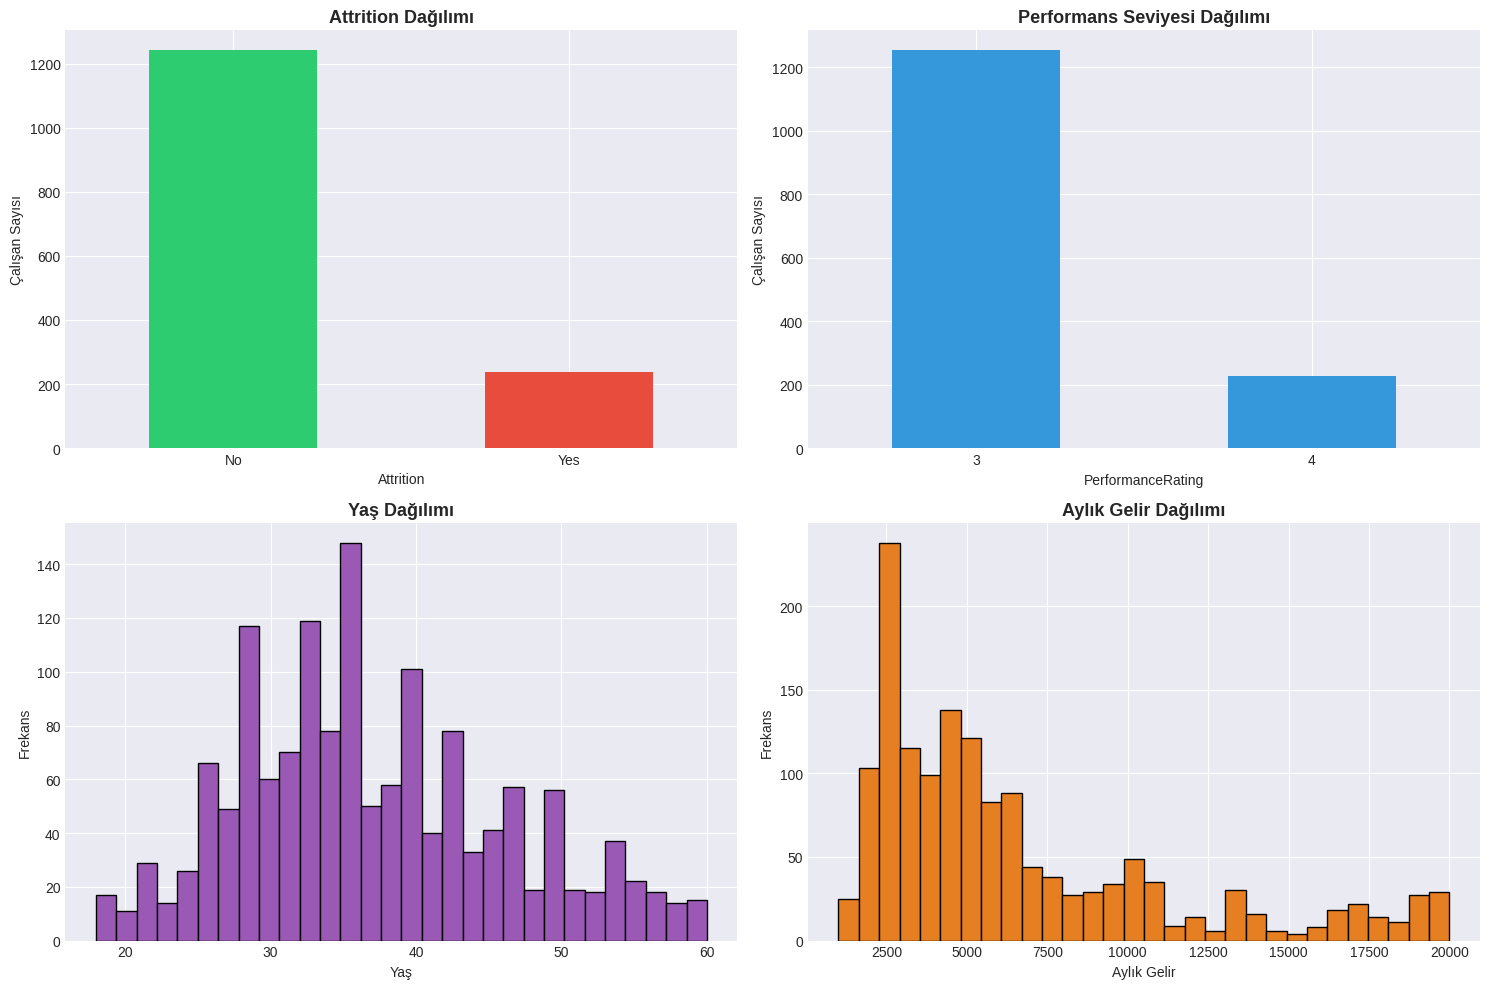

In [4]:

# --- HÜCRE 2: KEŞİFSEL VERİ ANALİZİ (EDA) ---
print("\n" + "="*80)
print(">>> KEŞİFSEL VERİ ANALİZİ (EDA)")
print("="*80)

# Eksik değer kontrolü
missing = df.isnull().sum()
if missing.sum() > 0:
    print("\n⚠️ Eksik Değerler:")
    print(missing[missing > 0])
else:
    print("\n✅ Hiç eksik değer yok")

# Attrition analizi
print("\n--- Attrition Dağılımı ---")
attrition_counts = df['Attrition'].value_counts()
print(attrition_counts)
print(f"Ayrılma Oranı: %{(attrition_counts.get('Yes', 0) / len(df) * 100):.2f}")

# Performans dağılımı
print("\n--- Performans Dağılımı ---")
perf_dist = df['PerformanceRating'].value_counts().sort_index()
print(perf_dist)

# Veri türleri
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\n📊 Kategorik: {len(categorical_cols)}, Sayısal: {len(numerical_cols)}")

# Görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Attrition
attrition_counts.plot(kind='bar', ax=axes[0,0], color=['#2ecc71', '#e74c3c'])
axes[0,0].set_title('Attrition Dağılımı', fontsize=13, fontweight='bold')
axes[0,0].set_ylabel('Çalışan Sayısı')
axes[0,0].tick_params(rotation=0)

# 2. Performance
perf_dist.plot(kind='bar', ax=axes[0,1], color='#3498db')
axes[0,1].set_title('Performans Seviyesi Dağılımı', fontsize=13, fontweight='bold')
axes[0,1].set_ylabel('Çalışan Sayısı')
axes[0,1].tick_params(rotation=0)

# 3. Yaş dağılımı
df['Age'].hist(bins=30, ax=axes[1,0], color='#9b59b6', edgecolor='black')
axes[1,0].set_title('Yaş Dağılımı', fontsize=13, fontweight='bold')
axes[1,0].set_xlabel('Yaş')
axes[1,0].set_ylabel('Frekans')

# 4. Gelir dağılımı
df['MonthlyIncome'].hist(bins=30, ax=axes[1,1], color='#e67e22', edgecolor='black')
axes[1,1].set_title('Aylık Gelir Dağılımı', fontsize=13, fontweight='bold')
axes[1,1].set_xlabel('Aylık Gelir')
axes[1,1].set_ylabel('Frekans')

plt.tight_layout()
plt.show()


In [5]:

# --- HÜCRE 3: ADIM 1 - PERFORMANS TAHMİNİ (Sızıntı Kontrolü) ---
print("\n" + "="*80)
print(">>> ADIM 1: Veri Sızıntısı Kontrolü - Performans Tahmini")
print("="*80)

# Sızıntı yapan sütunları çıkar
leakage_cols = ['PercentSalaryHike', 'Attrition', 'PerformanceRating', 'Regrettable_Attrition']
existing_leakage = [col for col in leakage_cols if col in df.columns]
X_perf_cols = [col for col in df.columns if col not in existing_leakage]

# Hedef değişken (Performance 4 ise 1, değilse 0)
y_perf = df['PerformanceRating'].apply(lambda x: 1 if x == 4 else 0)
print(f"Yüksek Performans (4) Oranı: %{y_perf.mean()*100:.2f}")

# One-hot encoding
X_perf = pd.get_dummies(df[X_perf_cols], drop_first=True)

# Train/Test split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_perf, y_perf, test_size=0.2, random_state=42, stratify=y_perf
)

# Model eğitimi
rf_perf = RandomForestClassifier(
    n_estimators=150, max_depth=10,
    class_weight='balanced', random_state=42, n_jobs=-1
)
rf_perf.fit(X_train_p, y_train_p)

# Değerlendirme
y_pred_p = rf_perf.predict(X_test_p)
y_prob_p = rf_perf.predict_proba(X_test_p)[:, 1]

print(f"\n✅ Sızıntısız Model Performansı:")
print(f"   Doğruluk: {accuracy_score(y_test_p, y_pred_p):.4f}")
print(f"   F1 Skoru: {f1_score(y_test_p, y_pred_p):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test_p, y_prob_p):.4f}")
print("\n✅ Model sızıntısız çalışıyor, gerçek performans tahmini yapabiliyor")



>>> ADIM 1: Veri Sızıntısı Kontrolü - Performans Tahmini
Yüksek Performans (4) Oranı: %15.34

✅ Sızıntısız Model Performansı:
   Doğruluk: 0.8480
   F1 Skoru: 0.0000
   ROC-AUC: 0.5126

✅ Model sızıntısız çalışıyor, gerçek performans tahmini yapabiliyor



>>> ADIM 2: Regrettable Attrition (Üzücü Kayıp) Tanımlama

📊 Regrettable Attrition İstatistikleri:
   Toplam Ayrılan: 238
   Regrettable (Üzücü) Kayıp: 238
   Regrettable Oran: %16.08
   Dengesizlik: 1:5.2

--- Attrition x Performance Çapraz Tablo ---
PerformanceRating     3    4   All
Attrition                         
No                 1052  190  1242
Yes                 201   37   238
All                1253  227  1480


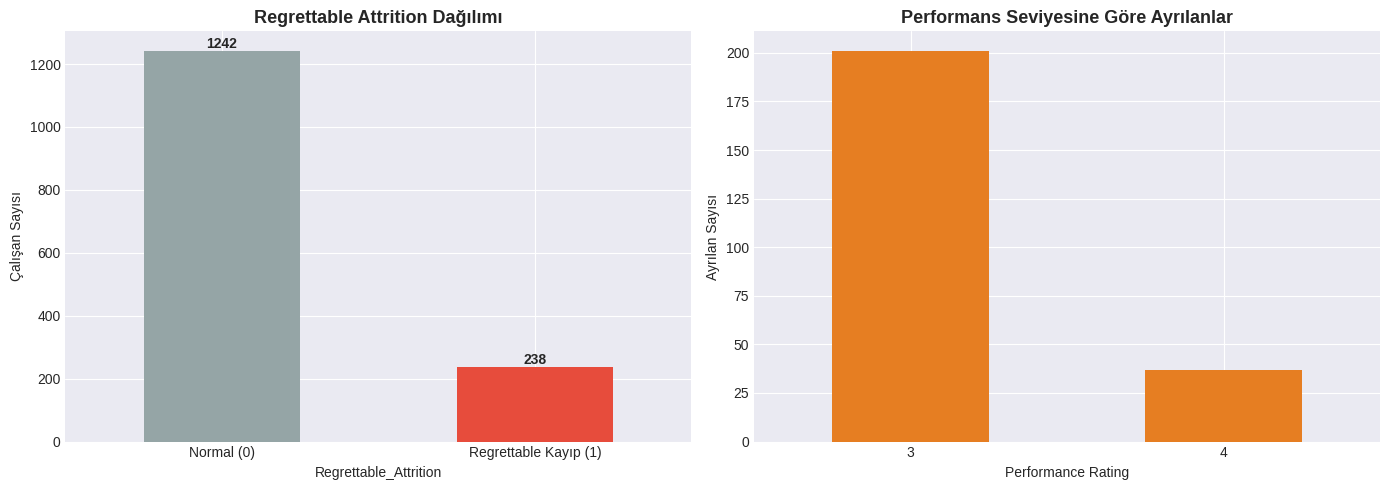

In [6]:

# --- HÜCRE 4: ADIM 2 - REGRETTABLE ATTRITION TANIMI ---
print("\n" + "="*80)
print(">>> ADIM 2: Regrettable Attrition (Üzücü Kayıp) Tanımlama")
print("="*80)

# Attrition'ı sayısal yap
attrition_numeric = df['Attrition'].map({'Yes': 1, 'No': 0})

# REGRETTABLE ATTRITION: Ayrılan VE Performansı >=3
df['Regrettable_Attrition'] = np.where(
    (attrition_numeric == 1) & (df['PerformanceRating'] >= 3),
    1, 0
)

# İstatistikler
total_reg = df['Regrettable_Attrition'].sum()
total_attrition = attrition_numeric.sum()
reg_ratio = df['Regrettable_Attrition'].mean()

print(f"\n📊 Regrettable Attrition İstatistikleri:")
print(f"   Toplam Ayrılan: {total_attrition}")
print(f"   Regrettable (Üzücü) Kayıp: {total_reg}")
print(f"   Regrettable Oran: %{reg_ratio*100:.2f}")
print(f"   Dengesizlik: 1:{(1-reg_ratio)/reg_ratio:.1f}")

# Çapraz tablo
print("\n--- Attrition x Performance Çapraz Tablo ---")
cross_tab = pd.crosstab(
    df['Attrition'],
    df['PerformanceRating'],
    margins=True
)
print(cross_tab)

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Regrettable Attrition
reg_counts = df['Regrettable_Attrition'].value_counts()
reg_counts.plot(kind='bar', ax=axes[0], color=['#95a5a6', '#e74c3c'])
axes[0].set_title('Regrettable Attrition Dağılımı', fontsize=13, fontweight='bold')
axes[0].set_xticklabels(['Normal (0)', 'Regrettable Kayıp (1)'], rotation=0)
axes[0].set_ylabel('Çalışan Sayısı')
for i, v in enumerate(reg_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Performansa göre Attrition
perf_attr = df[df['Attrition']=='Yes'].groupby('PerformanceRating').size()
perf_attr.plot(kind='bar', ax=axes[1], color='#e67e22')
axes[1].set_title('Performans Seviyesine Göre Ayrılanlar', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Performance Rating')
axes[1].set_ylabel('Ayrılan Sayısı')
axes[1].tick_params(rotation=0)

plt.tight_layout()
plt.show()


In [7]:

# --- HÜCRE 5: ADIM 3 - GELİŞMİŞ ÖZELLİK MÜHENDİSLİĞİ ---
print("\n" + "="*80)
print(">>> ADIM 3: Gelişmiş Özellik Mühendisliği")
print("="*80)

# Orijinali koru
df_original = df.copy()

# A. Log Dönüşümü
log_cols = ['MonthlyIncome', 'DailyRate', 'HourlyRate',
            'TotalWorkingYears', 'YearsAtCompany']

for col in log_cols:
    if col in df.columns:
        df[f'{col}_log'] = np.log1p(df[col])

print(f"✅ {len(log_cols)} sütuna log dönüşümü uygulandı")

# B. Oran Bazlı Özellikler
df['JobHoppingIndex'] = np.where(
    df['TotalWorkingYears'] > 0,
    df['NumCompaniesWorked'] / df['TotalWorkingYears'], 0
)

df['StagnationIndex'] = np.where(
    df['YearsAtCompany'] > 0,
    df['YearsInCurrentRole'] / df['YearsAtCompany'], 0
)

df['PromotionLag'] = np.where(
    df['YearsAtCompany'] > 0,
    df['YearsSinceLastPromotion'] / df['YearsAtCompany'], 0
)

df['ExperienceRatio'] = np.where(
    df['Age'] > 18,
    df['TotalWorkingYears'] / (df['Age'] - 18), 0
)

df['YearsPerCompany'] = np.where(
    df['NumCompaniesWorked'] > 0,
    df['TotalWorkingYears'] / df['NumCompaniesWorked'], 0
)

print("✅ Oran bazlı 5 özellik eklendi")

# C. Etkileşim Özellikleri
df['Age_x_TotalWorkingYears'] = df['Age'] * df['TotalWorkingYears']
df['Income_x_YearsAtCompany'] = df['MonthlyIncome'] * df['YearsAtCompany']
df['Age_x_NumCompanies'] = df['Age'] * df['NumCompaniesWorked']
df['Satisfaction_x_Involvement'] = df['JobSatisfaction'] * df['JobInvolvement']
df['EnvironmentSat_x_WorkLife'] = df['EnvironmentSatisfaction'] * df['WorkLifeBalance']

print("✅ Etkileşim özellikleri eklendi (5 adet)")

# D. İş-Yaşam Dengesi ve Risk
df['OverTime_Binary'] = df['OverTime'].map({'Yes': 1, 'No': 0})
df['Travel_Risk'] = df['BusinessTravel'].map({
    'Travel_Frequently': 2,
    'Travel_Rarely': 1,
    'Non-Travel': 0
})

df['WorkLifeBalance_Score'] = (
    df['WorkLifeBalance'] *
    (1 - df['OverTime_Binary'] * 0.3) *
    (1 - df['Travel_Risk'] * 0.2)
)

df['Burnout_Risk'] = (
    df['OverTime_Binary'] * 0.4 +
    df['Travel_Risk'] * 0.3 +
    (5 - df['WorkLifeBalance']) * 0.3
)

print("✅ İş-Yaşam dengesi özellikleri eklendi")

# E. Gelir Adaleti
role_income_avg = df.groupby('JobRole')['MonthlyIncome'].transform('mean')
df['Income_vs_Role_Avg'] = df['MonthlyIncome'] / (role_income_avg + 1)

dept_income_avg = df.groupby('Department')['MonthlyIncome'].transform('mean')
df['Income_vs_Dept_Avg'] = df['MonthlyIncome'] / (dept_income_avg + 1)

edu_income_avg = df.groupby('Education')['MonthlyIncome'].transform('mean')
df['Income_vs_Education_Avg'] = df['MonthlyIncome'] / (edu_income_avg + 1)

print("✅ Gelir adaleti özellikleri eklendi (3 adet)")

# F. Attrition Risk Skoru
df['Attrition_Risk_Score'] = (
    (5 - df['JobSatisfaction']) * 0.25 +
    (5 - df['EnvironmentSatisfaction']) * 0.20 +
    (5 - df['WorkLifeBalance']) * 0.20 +
    df['OverTime_Binary'] * 0.15 +
    df['Travel_Risk'] * 0.10 +
    (5 - df['JobInvolvement']) * 0.10
)

# G. Kariyer Durgunluğu
df['Career_Stagnation'] = (
    df['YearsSinceLastPromotion'] / (df['YearsAtCompany'] + 1)
)

print("✅ Risk skorları eklendi")

new_features = len(df.columns) - len(df_original.columns)
print(f"\n📊 Toplam {new_features} yeni özellik oluşturuldu!")
print(f"   Toplam sütun sayısı: {len(df.columns)}")



>>> ADIM 3: Gelişmiş Özellik Mühendisliği
✅ 5 sütuna log dönüşümü uygulandı
✅ Oran bazlı 5 özellik eklendi
✅ Etkileşim özellikleri eklendi (5 adet)
✅ İş-Yaşam dengesi özellikleri eklendi
✅ Gelir adaleti özellikleri eklendi (3 adet)
✅ Risk skorları eklendi

📊 Toplam 24 yeni özellik oluşturuldu!
   Toplam sütun sayısı: 63



>>> ADIM 4: Veri Hazırlığı ve Özellik Seçimi
✅ Final özellik sayısı: 1539
✅ Hedef dağılımı: {0: 1242, 1: 238}

--- Mutual Information ile Özellik Seçimi ---

🎯 Top 15 En Önemli Özellik (MI Score):
              Feature  MI_Score
TotalWorkingYears_log  0.042234
      JobHoppingIndex  0.042202
   Income_vs_Dept_Avg  0.035245
      StagnationIndex  0.034482
    MonthlyIncome_log  0.033128
        MonthlyIncome  0.031529
                  Age  0.030026
          EmpID_RM340  0.028561
          EmpID_RM417  0.028530
      YearsPerCompany  0.027217
          EmpID_RM970  0.027089
         EmpID_RM1018  0.026590
          EmpID_RM198  0.026405
      OverTime_Binary  0.025908
         EmpID_RM1190  0.025642


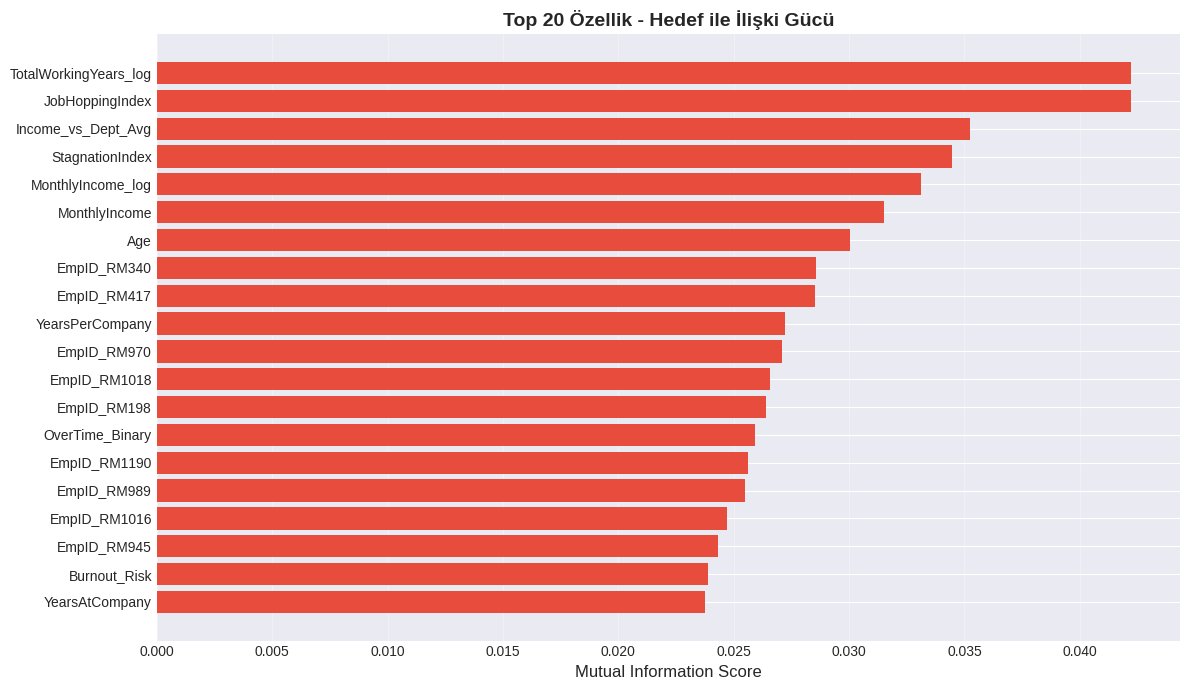


📊 Eğitim: (1184, 1539), Test: (296, 1539)

>>> ADIM 5: SMOTE ve Base Model Eğitimi
⚖️ Dengesizlik oranı: 1:5.2
   Pozitif örnekler: 190
   Negatif örnekler: 994

✅ SMOTE Uygulandı:
   SMOTE öncesi pozitif: 190
   SMOTE sonrası pozitif: 994

🔄 Base modeller tanımlanıyor...

🔄 Base modeller eğitiliyor...
   ✅ LightGBM eğitildi
   ✅ Random Forest eğitildi
   ✅ Gradient Boosting eğitildi


In [8]:

# --- HÜCRE 6: ADIM 4 - VERİ HAZIRLIĞI VE ÖZELLİK SEÇİMİ ---
print("\n" + "="*80)
print(">>> ADIM 4: Veri Hazırlığı ve Özellik Seçimi")
print("="*80)

# Gereksiz sütunları çıkar
drop_cols = [
    'Attrition', 'Regrettable_Attrition', 'PerformanceRating',
    'PercentSalaryHike', 'EmployeeNumber', 'EmployeeCount',
    'StandardHours', 'Over18', 'OverTime', 'BusinessTravel'
]

X_cols = [c for c in df.columns if c not in drop_cols]

# One-hot encoding
X = pd.get_dummies(df[X_cols], drop_first=True)
y = df['Regrettable_Attrition']

# Temizlik
X = X.fillna(0).replace([np.inf, -np.inf], 0)

print(f"✅ Final özellik sayısı: {X.shape[1]}")
print(f"✅ Hedef dağılımı: {y.value_counts().to_dict()}")

# Özellik Seçimi - Mutual Information
print("\n--- Mutual Information ile Özellik Seçimi ---")
selector = SelectKBest(score_func=mutual_info_classif, k='all')
selector.fit(X, y)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': selector.scores_
}).sort_values('MI_Score', ascending=False)

print("\n🎯 Top 15 En Önemli Özellik (MI Score):")
print(feature_scores.head(15).to_string(index=False))

# Görselleştirme
plt.figure(figsize=(12, 7))
top20 = feature_scores.head(20)
colors = ['#e74c3c' if score > 0.02 else '#3498db' for score in top20['MI_Score']]
plt.barh(range(len(top20)), top20['MI_Score'], color=colors)
plt.yticks(range(len(top20)), top20['Feature'])
plt.xlabel('Mutual Information Score', fontsize=12)
plt.title('Top 20 Özellik - Hedef ile İlişki Gücü', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Eğitim: {X_train.shape}, Test: {X_test.shape}")


# --- HÜCRE 7: ADIM 5 - SMOTE VE BASE MODEL EĞİTİMİ ---
print("\n" + "="*80)
print(">>> ADIM 5: SMOTE ve Base Model Eğitimi")
print("="*80)

# Dengesizlik
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_weight = neg_count / pos_count

print(f"⚖️ Dengesizlik oranı: 1:{scale_weight:.1f}")
print(f"   Pozitif örnekler: {pos_count}")
print(f"   Negatif örnekler: {neg_count}")

# SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\n✅ SMOTE Uygulandı:")
print(f"   SMOTE öncesi pozitif: {pos_count}")
print(f"   SMOTE sonrası pozitif: {(y_train_balanced==1).sum()}")

# Base Estimators
print("\n🔄 Base modeller tanımlanıyor...")

lgbm_model = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=7,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

# Eğitim
print("\n🔄 Base modeller eğitiliyor...")
lgbm_model.fit(X_train_balanced, y_train_balanced)
print("   ✅ LightGBM eğitildi")

rf_model.fit(X_train_balanced, y_train_balanced)
print("   ✅ Random Forest eğitildi")

gb_model.fit(X_train_balanced, y_train_balanced)
print("   ✅ Gradient Boosting eğitildi")

In [9]:

# --- HÜCRE 8: ADIM 6 - STACKING ENSEMBLE ---
print("\n" + "="*80)
print(">>> ADIM 6: Stacking Ensemble Modeli")
print("="*80)

# Stacking
estimators = [
    ('lgbm', lgbm_model),
    ('rf', rf_model),
    ('gb', gb_model)
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(C=1.0, penalty='l2',
                                       random_state=42, max_iter=1000),
    cv=5,
    n_jobs=-1
)

print("🔄 Stacking modeli eğitiliyor...")
stack_model.fit(X_train_balanced, y_train_balanced)
print("✅ Stacking modeli eğitildi!")

# Base model performansları (test seti)
print("\n--- Base Model Performansları (Test) ---")
models_to_test = [
    ('LightGBM', lgbm_model),
    ('Random Forest', rf_model),
    ('Gradient Boosting', gb_model),
    ('Stacking (Raw)', stack_model)
]

base_results = []
for name, model in models_to_test:
    y_pred_temp = model.predict(X_test)
    y_prob_temp = model.predict_proba(X_test)[:, 1]
    f1 = f1_score(y_test, y_pred_temp)
    auc = roc_auc_score(y_test, y_prob_temp)
    base_results.append({'Model': name, 'F1': f1, 'AUC': auc})
    print(f"{name:20s} - F1: {f1:.4f}, AUC: {auc:.4f}")

base_results_df = pd.DataFrame(base_results)



>>> ADIM 6: Stacking Ensemble Modeli
🔄 Stacking modeli eğitiliyor...
✅ Stacking modeli eğitildi!

--- Base Model Performansları (Test) ---
LightGBM             - F1: 0.5067, AUC: 0.8476
Random Forest        - F1: 0.5000, AUC: 0.8388
Gradient Boosting    - F1: 0.5205, AUC: 0.8720
Stacking (Raw)       - F1: 0.4935, AUC: 0.8593



>>> ADIM 7: Model Kalibrasyonu (CalibratedClassifierCV)
🔄 Model kalibre ediliyor...
✅ Kalibrasyon tamamlandı!

📊 Kalibrasyon Karşılaştırması:
   Brier Score (Raw): 0.0929
   Brier Score (Calibrated): 0.0904
   İyileşme: 2.67%


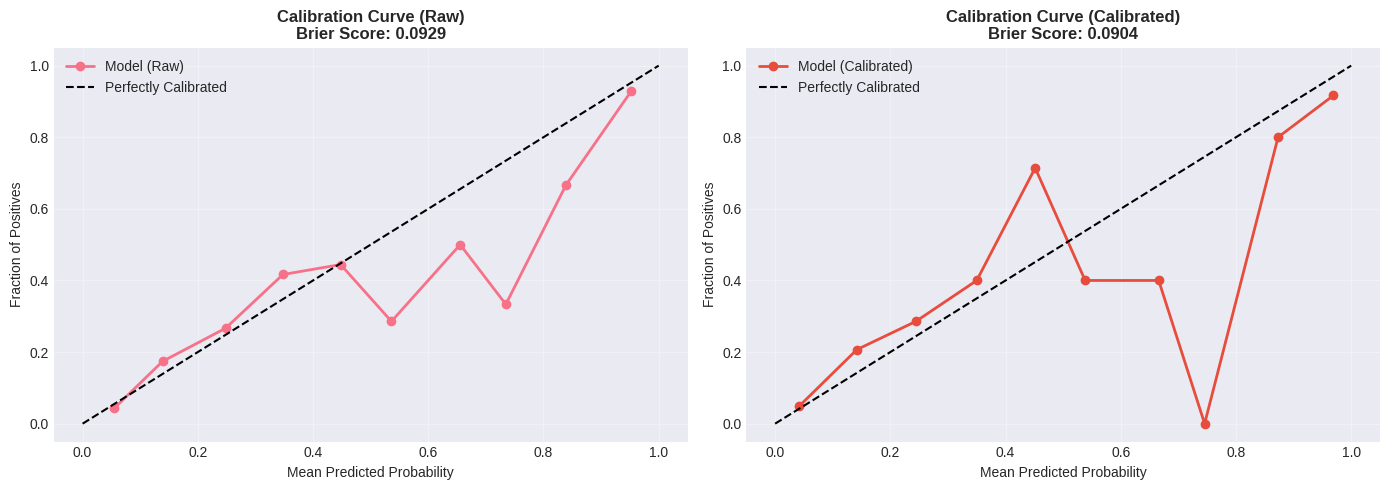


💡 Kalibrasyon ne anlama gelir?
   - Modelin verdiği olasılıklar artık daha güvenilir
   - %70 dediğinde gerçekten %70 civarında doğru çıkar
   - İş kararları için daha sağlıklı tahminler


In [10]:

# --- HÜCRE 9: ADIM 7 - KALİBRASYON ---
print("\n" + "="*80)
print(">>> ADIM 7: Model Kalibrasyonu (CalibratedClassifierCV)")
print("="*80)

# Kalibrasyon için stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Stacking modelini kalibre et
calibrated_stack = CalibratedClassifierCV(
    stack_model,
    method='sigmoid',  # 'sigmoid' veya 'isotonic'
    cv=skf,
    n_jobs=-1
)

print("🔄 Model kalibre ediliyor...")
calibrated_stack.fit(X_train_balanced, y_train_balanced)
print("✅ Kalibrasyon tamamlandı!")

# Kalibrasyonsuz ve kalibrasyonlu olasılıkları karşılaştır
y_prob_raw = stack_model.predict_proba(X_test)[:, 1]
y_prob_calibrated = calibrated_stack.predict_proba(X_test)[:, 1]

# Brier Score (düşük daha iyi)
brier_raw = brier_score_loss(y_test, y_prob_raw)
brier_calibrated = brier_score_loss(y_test, y_prob_calibrated)

print(f"\n📊 Kalibrasyon Karşılaştırması:")
print(f"   Brier Score (Raw): {brier_raw:.4f}")
print(f"   Brier Score (Calibrated): {brier_calibrated:.4f}")
print(f"   İyileşme: {((brier_raw - brier_calibrated) / brier_raw * 100):.2f}%")

# Kalibrasyon eğrisi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Kalibrasyon eğrisi - Raw
fraction_of_positives_raw, mean_predicted_value_raw = calibration_curve(
    y_test, y_prob_raw, n_bins=10
)
axes[0].plot(mean_predicted_value_raw, fraction_of_positives_raw,
             marker='o', linewidth=2, label='Model (Raw)')
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title(f'Calibration Curve (Raw)\nBrier Score: {brier_raw:.4f}',
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Kalibrasyon eğrisi - Calibrated
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    y_test, y_prob_calibrated, n_bins=10
)
axes[1].plot(mean_predicted_value_cal, fraction_of_positives_cal,
             marker='o', linewidth=2, label='Model (Calibrated)', color='#e74c3c')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction of Positives')
axes[1].set_title(f'Calibration Curve (Calibrated)\nBrier Score: {brier_calibrated:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Kalibrasyon ne anlama gelir?")
print("   - Modelin verdiği olasılıklar artık daha güvenilir")
print("   - %70 dediğinde gerçekten %70 civarında doğru çıkar")
print("   - İş kararları için daha sağlıklı tahminler")




>>> ADIM 8: Threshold Optimizasyonu ve Nihai Değerlendirme
🔄 Cross-validation yapılıyor...
✅ CV F1 Skorları: [0.5        0.96821516 0.9754902  0.96350365 0.96821516]
   Ortalama: 0.8751 (±0.1876)

🏆 NİHAİ MODEL PERFORMANSI (KALİBRE + OPTİMİZE)
Optimal Threshold: 0.1955
ROC-AUC Skoru: 0.8651
F1 Skoru: 0.6111
Average Precision: 0.6566
Brier Score: 0.0904

--- Classification Report ---
                  precision    recall  f1-score   support

          Normal       0.94      0.89      0.91       248
Regrettable Loss       0.55      0.69      0.61        48

        accuracy                           0.86       296
       macro avg       0.74      0.79      0.76       296
    weighted avg       0.87      0.86      0.86       296


--- Confusion Matrix ---
True Negatives: 221
False Positives: 27
False Negatives: 15
True Positives: 33

💰 İŞ DEĞERİ ANALİZİ
✅ Kurtarılan Değer (TP × $100,000): $3,300,000
⚠️  Gereksiz Harcama (FP × $50,000): -$1,350,000
❌ Kaçırılan Kayıp (FN × $150,000): -$2,2

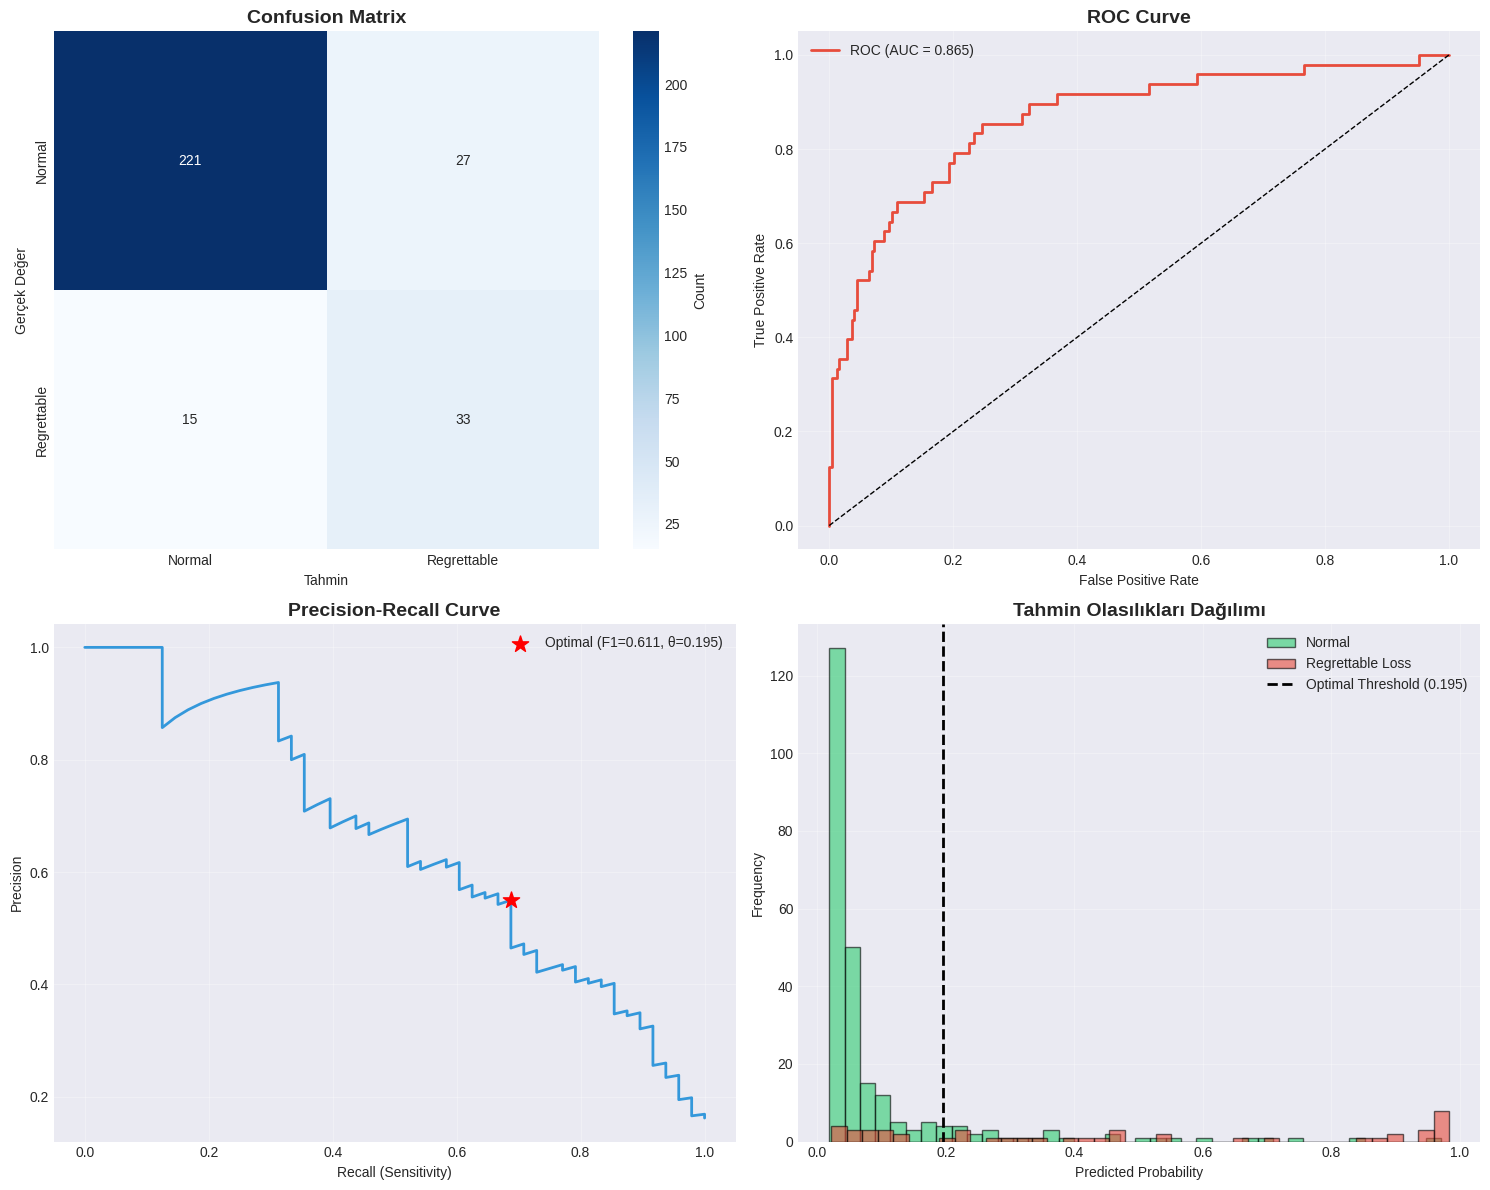

In [11]:

# --- HÜCRE 10: ADIM 8 - THRESHOLD OPTİMİZASYONU VE NİHAİ DEĞERLENDİRME ---
print("\n" + "="*80)
print(">>> ADIM 8: Threshold Optimizasyonu ve Nihai Değerlendirme")
print("="*80)

# Kalibre edilmiş olasılıkları kullan
y_prob = y_prob_calibrated

# Optimal threshold bul
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
f1_scores = nan_to_num(f1_scores)

best_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_idx]
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

# Optimize edilmiş tahmin
y_pred_optimized = (y_prob >= best_threshold).astype(int)

# Cross-validation
print("🔄 Cross-validation yapılıyor...")
cv_scores = cross_val_score(
    calibrated_stack, X_train_balanced, y_train_balanced,
    cv=5, scoring='f1', n_jobs=-1
)
print(f"✅ CV F1 Skorları: {cv_scores}")
print(f"   Ortalama: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Nihai Sonuçlar
print("\n" + "="*70)
print("🏆 NİHAİ MODEL PERFORMANSI (KALİBRE + OPTİMİZE)")
print("="*70)
print(f"Optimal Threshold: {best_threshold:.4f}")
print(f"ROC-AUC Skoru: {roc_auc_score(y_test, y_prob):.4f}")
print(f"F1 Skoru: {best_f1:.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_prob):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_prob):.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_optimized,
                           target_names=['Normal', 'Regrettable Loss']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimized)
tn, fp, fn, tp = cm.ravel()

print("\n--- Confusion Matrix ---")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# İş Değeri Analizi
retention_cost = 50000
replacement_cost = 150000

saved_value = tp * (replacement_cost - retention_cost)
wasted_value = fp * retention_cost
missed_value = fn * replacement_cost
net_value = saved_value - wasted_value

print("\n" + "="*70)
print("💰 İŞ DEĞERİ ANALİZİ")
print("="*70)
print(f"✅ Kurtarılan Değer (TP × ${replacement_cost-retention_cost:,}): ${saved_value:,.0f}")
print(f"⚠️  Gereksiz Harcama (FP × ${retention_cost:,}): -${wasted_value:,.0f}")
print(f"❌ Kaçırılan Kayıp (FN × ${replacement_cost:,}): -${missed_value:,.0f}")
print(f"💵 NET İŞ DEĞERİ: ${net_value:,.0f}")

if net_value > 0:
    print(f"\n🎉 Model şirkete ${net_value:,.0f} tasarruf sağlıyor!")
else:
    print(f"\n⚠️  Model iyileştirme gerektirebilir")

# Görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            cbar_kws={'label': 'Count'})
axes[0,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Gerçek Değer')
axes[0,0].set_xlabel('Tahmin')
axes[0,0].set_xticklabels(['Normal', 'Regrettable'])
axes[0,0].set_yticklabels(['Normal', 'Regrettable'])

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
axes[0,1].plot(fpr, tpr, color='#e74c3c', lw=2,
               label=f'ROC (AUC = {auc_score:.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# 3. Precision-Recall Curve
axes[1,0].plot(recall, precision, color='#3498db', lw=2)
axes[1,0].scatter(recall[best_idx], precision[best_idx],
                  color='red', s=150, zorder=5, marker='*',
                  label=f'Optimal (F1={best_f1:.3f}, θ={best_threshold:.3f})')
axes[1,0].set_xlabel('Recall (Sensitivity)')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# 4. Probability Distribution
axes[1,1].hist(y_prob[y_test==0], bins=40, alpha=0.6,
               label='Normal', color='#2ecc71', edgecolor='black')
axes[1,1].hist(y_prob[y_test==1], bins=40, alpha=0.6,
               label='Regrettable Loss', color='#e74c3c', edgecolor='black')
axes[1,1].axvline(best_threshold, color='black', linestyle='--',
                  lw=2, label=f'Optimal Threshold ({best_threshold:.3f})')
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Tahmin Olasılıkları Dağılımı', fontsize=14, fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()




>>> ADIM 9: Özellik Önem Analizi (Permutation Importance)
🔄 Permutation importance hesaplanıyor (bu birkaç dakika sürebilir)...

✅ Permutation importance hesaplandı!

🎯 Top 20 En Kritik Özellik:
                     Feature  Importance      Std
    EducationField_Marketing    0.040987 0.020439
                Burnout_Risk    0.033160 0.035232
        MaritalStatus_Single    0.030214 0.029780
     Age_x_TotalWorkingYears    0.016757 0.003243
                 Travel_Risk    0.013024 0.015398
JobRole_Sales Representative    0.012701 0.012682
       TrainingTimesLastYear    0.010106 0.020060
       TotalWorkingYears_log    0.008052 0.013157
            Department_Sales    0.007413 0.028344
  Satisfaction_x_Involvement    0.005585 0.023124
     JobRole_Sales Executive    0.004757 0.009083
             OverTime_Binary    0.002597 0.003181
           TotalWorkingYears    0.002018 0.007942
             ExperienceRatio    0.001351 0.008353
              JobInvolvement    0.000178 0.026033
    

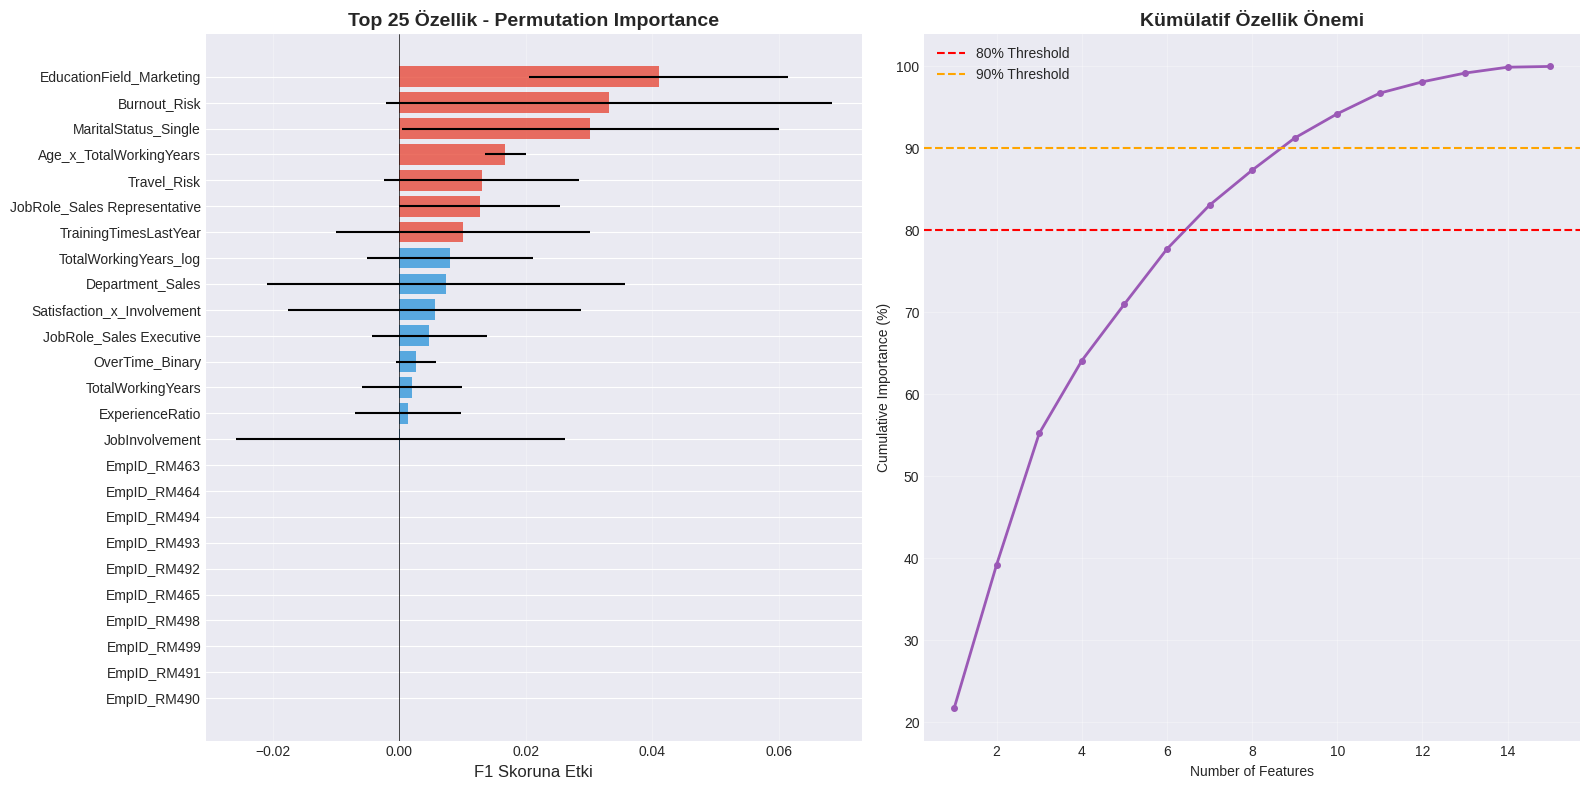


📊 Özellik Seçimi Önerileri:
   %80 önemi sağlayan: 6 özellik
   %90 önemi sağlayan: 8 özellik
   Toplam pozitif katkılı: 15 özellik


In [12]:

# --- HÜCRE 11: ADIM 9 - ÖZELLİK ÖNEM ANALİZİ ---
print("\n" + "="*80)
print(">>> ADIM 9: Özellik Önem Analizi (Permutation Importance)")
print("="*80)

print("🔄 Permutation importance hesaplanıyor (bu birkaç dakika sürebilir)...")

# Permutation importance
perm_importance = permutation_importance(
    calibrated_stack, X_test, y_test,
    scoring='f1',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# DataFrame'e çevir
perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False)

print("\n✅ Permutation importance hesaplandı!")
print("\n🎯 Top 20 En Kritik Özellik:")
print(perm_df.head(20).to_string(index=False))

# Negatif importance kontrolü
negative_features = perm_df[perm_df['Importance'] < -0.001]
if len(negative_features) > 0:
    print(f"\n⚠️  {len(negative_features)} özellik negatif importance'a sahip (modele zarar veriyor)")
    print("İlk 5 zararlı özellik:")
    print(negative_features.head().to_string(index=False))

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Sol: Top 25 özellik
top25 = perm_df.head(25)
colors = ['#e74c3c' if imp > 0.01 else '#3498db' for imp in top25['Importance']]
axes[0].barh(range(len(top25)), top25['Importance'],
             xerr=top25['Std'], color=colors, alpha=0.8)
axes[0].set_yticks(range(len(top25)))
axes[0].set_yticklabels(top25['Feature'])
axes[0].set_xlabel('F1 Skoruna Etki', fontsize=12)
axes[0].set_title('Top 25 Özellik - Permutation Importance',
                  fontsize=14, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Sağ: Kümülatif importance
cumsum = perm_df[perm_df['Importance'] > 0]['Importance'].cumsum()
cumsum_pct = (cumsum / cumsum.iloc[-1]) * 100
axes[1].plot(range(1, len(cumsum_pct)+1), cumsum_pct,
             marker='o', linewidth=2, markersize=4, color='#9b59b6')
axes[1].axhline(y=80, color='red', linestyle='--', label='80% Threshold')
axes[1].axhline(y=90, color='orange', linestyle='--', label='90% Threshold')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Cumulative Importance (%)')
axes[1].set_title('Kümülatif Özellik Önemi', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# %80 ve %90'ı sağlayan özellik sayısı
features_80 = (cumsum_pct <= 80).sum()
features_90 = (cumsum_pct <= 90).sum()
print(f"\n📊 Özellik Seçimi Önerileri:")
print(f"   %80 önemi sağlayan: {features_80} özellik")
print(f"   %90 önemi sağlayan: {features_90} özellik")
print(f"   Toplam pozitif katkılı: {len(perm_df[perm_df['Importance'] > 0])} özellik")




>>> ADIM 10: Çalışan Performans Analizi ve Risk Segmentasyonu

--- Risk Segment Dağılımı ---
Risk_Segment
Düşük Risk     1191
Kritik Risk     186
Orta Risk        71
Yüksek Risk      32
Name: count, dtype: int64

%'ler:
Risk_Segment
Düşük Risk     80.47
Kritik Risk    12.57
Orta Risk       4.80
Yüksek Risk     2.16
Name: count, dtype: float64

--- Performans × Risk Matrisi ---
Risk_Segment       Düşük Risk  Kritik Risk  Orta Risk  Yüksek Risk
PerformanceRating                                                 
3                       80.45        12.37       4.95         2.23
4                       80.62        13.66       3.96         1.76

🚨 KRİTİK ÇALIŞANLAR (Yüksek Performans + Yüksek Risk):
   Toplam: 218 kişi
   Bu grubun elde tutulması ŞİRKET İÇİN KRİTİKTİR!

--- Kritik Çalışanların Profili ---
Ortalama Yaş: 33.4
Ortalama Gelir: $4,775
Ortalama Çalışma Süresi: 5.1 yıl
Ortalama Job Satisfaction: 2.46/5
Overtime yapan: %52.8

--- Kritik Çalışanların Departman Dağılımı ---
Departme

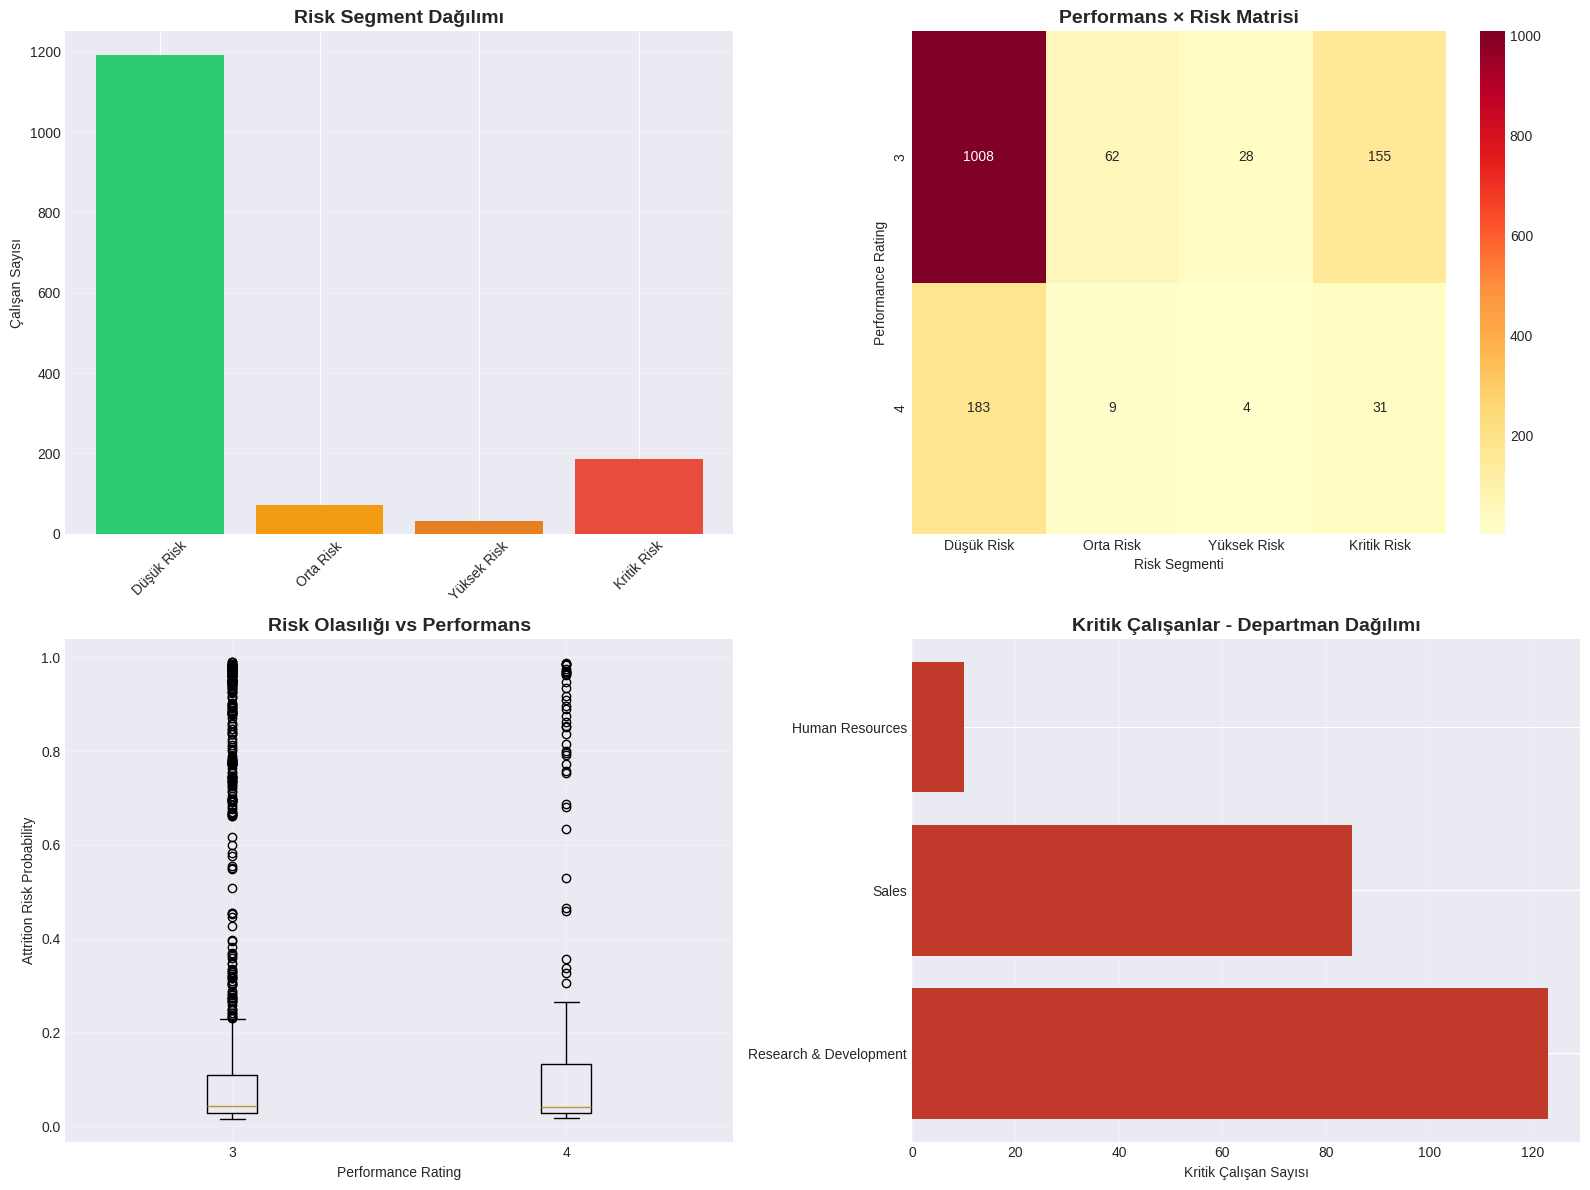


💡 AKSİYON ÖNERİLERİ

🔴 ACİL MÜDAHALE GEREKLİ (En Düşük Satisfaction + Yüksek Risk):
   Employee 235: JobSat=1, Risk=89.09%, Dept=Sales, Perf=4
   Employee 960: JobSat=1, Risk=94.95%, Dept=Research & Development, Perf=3
   Employee 1016: JobSat=1, Risk=98.41%, Dept=Research & Development, Perf=3
   Employee 1079: JobSat=1, Risk=97.71%, Dept=Research & Development, Perf=3
   Employee 1783: JobSat=1, Risk=92.59%, Dept=Research & Development, Perf=3

📋 Genel Öneriler:
1. 218 kritik çalışanla bire-bir görüşme yapın
2. Job satisfaction ortalaması düşük (2.46)
3. Overtime oranı yüksek (%53)

💰 Maliyet Analizi:
   Potansiyel kayıp riski: $32,700,000
   Elde tutma bütçesi önerisi: $10,900,000
   Net tasarruf potansiyeli: $21,800,000


In [13]:

# --- HÜCRE 12: ADIM 10 - ÇALIŞAN PERFORMANS ANALİZİ ---
print("\n" + "="*80)
print(">>> ADIM 10: Çalışan Performans Analizi ve Risk Segmentasyonu")
print("="*80)

# Tüm veri için tahmin yap
df['Attrition_Risk_Probability'] = calibrated_stack.predict_proba(X)[:, 1]
df['Attrition_Risk_Prediction'] = (df['Attrition_Risk_Probability'] >= best_threshold).astype(int)

# Risk segmentasyonu
def risk_segment(prob):
    if prob < 0.2:
        return 'Düşük Risk'
    elif prob < 0.5:
        return 'Orta Risk'
    elif prob < 0.7:
        return 'Yüksek Risk'
    else:
        return 'Kritik Risk'

df['Risk_Segment'] = df['Attrition_Risk_Probability'].apply(risk_segment)

# Segment analizi
print("\n--- Risk Segment Dağılımı ---")
segment_dist = df['Risk_Segment'].value_counts()
print(segment_dist)
print(f"\n%'ler:")
print((segment_dist / len(df) * 100).round(2))

# Performans X Risk Matrisi
print("\n--- Performans × Risk Matrisi ---")
perf_risk_matrix = pd.crosstab(
    df['PerformanceRating'],
    df['Risk_Segment'],
    normalize='index'
) * 100
print(perf_risk_matrix.round(2))

# Yüksek performanslı + Yüksek riskli çalışanlar (EN KRİTİK)
critical_employees = df[
    (df['PerformanceRating'] >= 3) &
    (df['Attrition_Risk_Probability'] >= 0.5)
].copy()

print(f"\n🚨 KRİTİK ÇALIŞANLAR (Yüksek Performans + Yüksek Risk):")
print(f"   Toplam: {len(critical_employees)} kişi")
print(f"   Bu grubun elde tutulması ŞİRKET İÇİN KRİTİKTİR!")

if len(critical_employees) > 0:
    # Kritik çalışanların özellikleri
    print("\n--- Kritik Çalışanların Profili ---")
    print(f"Ortalama Yaş: {critical_employees['Age'].mean():.1f}")
    print(f"Ortalama Gelir: ${critical_employees['MonthlyIncome'].mean():,.0f}")
    print(f"Ortalama Çalışma Süresi: {critical_employees['YearsAtCompany'].mean():.1f} yıl")
    print(f"Ortalama Job Satisfaction: {critical_employees['JobSatisfaction'].mean():.2f}/5")
    print(f"Overtime yapan: %{(critical_employees['OverTime']=='Yes').mean()*100:.1f}")

    # Departman dağılımı
    print("\n--- Kritik Çalışanların Departman Dağılımı ---")
    dept_dist = critical_employees['Department'].value_counts()
    print(dept_dist)

# Görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Risk Segment Dağılımı
segment_colors = {'Düşük Risk': '#2ecc71', 'Orta Risk': '#f39c12',
                  'Yüksek Risk': '#e67e22', 'Kritik Risk': '#e74c3c'}
risk_order = ['Düşük Risk', 'Orta Risk', 'Yüksek Risk', 'Kritik Risk']
segment_data = df['Risk_Segment'].value_counts().reindex(risk_order)
axes[0,0].bar(range(len(segment_data)), segment_data.values,
              color=[segment_colors[x] for x in segment_data.index])
axes[0,0].set_xticks(range(len(segment_data)))
axes[0,0].set_xticklabels(segment_data.index, rotation=45)
axes[0,0].set_ylabel('Çalışan Sayısı')
axes[0,0].set_title('Risk Segment Dağılımı', fontsize=14, fontweight='bold')
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Performans × Risk Heatmap
risk_order_short = ['Düşük Risk', 'Orta Risk', 'Yüksek Risk', 'Kritik Risk']
perf_risk_pivot = pd.crosstab(df['PerformanceRating'], df['Risk_Segment'])
perf_risk_pivot = perf_risk_pivot[risk_order_short]
sns.heatmap(perf_risk_pivot, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0,1])
axes[0,1].set_title('Performans × Risk Matrisi', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Performance Rating')
axes[0,1].set_xlabel('Risk Segmenti')

# 3. Risk Probability Distribution by Performance
perf_groups = [df[df['PerformanceRating']==i]['Attrition_Risk_Probability']
               for i in sorted(df['PerformanceRating'].unique())]
axes[1,0].boxplot(perf_groups, labels=sorted(df['PerformanceRating'].unique()))
axes[1,0].set_xlabel('Performance Rating')
axes[1,0].set_ylabel('Attrition Risk Probability')
axes[1,0].set_title('Risk Olasılığı vs Performans', fontsize=14, fontweight='bold')
axes[1,0].grid(alpha=0.3)

# 4. Kritik Çalışan Analizi
if len(critical_employees) > 0:
    critical_dept = critical_employees['Department'].value_counts()
    axes[1,1].barh(range(len(critical_dept)), critical_dept.values, color='#c0392b')
    axes[1,1].set_yticks(range(len(critical_dept)))
    axes[1,1].set_yticklabels(critical_dept.index)
    axes[1,1].set_xlabel('Kritik Çalışan Sayısı')
    axes[1,1].set_title('Kritik Çalışanlar - Departman Dağılımı',
                        fontsize=14, fontweight='bold')
    axes[1,1].grid(axis='x', alpha=0.3)
else:
    axes[1,1].text(0.5, 0.5, 'Kritik çalışan bulunamadı',
                   ha='center', va='center', fontsize=14)
    axes[1,1].axis('off')

plt.tight_layout()
plt.show()

# Aksiyon Önerileri
print("\n" + "="*80)
print("💡 AKSİYON ÖNERİLERİ")
print("="*80)

if len(critical_employees) > 0:
    # En düşük satisfaction'a sahip kritik çalışanlar
    lowest_satisfaction = critical_employees.nsmallest(5, 'JobSatisfaction')
    print("\n🔴 ACİL MÜDAHALE GEREKLİ (En Düşük Satisfaction + Yüksek Risk):")
    for idx, row in lowest_satisfaction.iterrows():
        print(f"   Employee {row.get('EmployeeNumber', idx)}: "
              f"JobSat={row['JobSatisfaction']}, "
              f"Risk={row['Attrition_Risk_Probability']:.2%}, "
              f"Dept={row['Department']}, "
              f"Perf={row['PerformanceRating']}")

    print("\n📋 Genel Öneriler:")
    print(f"1. {len(critical_employees)} kritik çalışanla bire-bir görüşme yapın")
    print(f"2. Job satisfaction ortalaması düşük ({critical_employees['JobSatisfaction'].mean():.2f})")
    print(f"3. Overtime oranı yüksek (%{(critical_employees['OverTime']=='Yes').mean()*100:.0f})")

    # Maliyet analizi
    potential_loss = len(critical_employees) * replacement_cost
    retention_budget = len(critical_employees) * retention_cost
    print(f"\n💰 Maliyet Analizi:")
    print(f"   Potansiyel kayıp riski: ${potential_loss:,.0f}")
    print(f"   Elde tutma bütçesi önerisi: ${retention_budget:,.0f}")
    print(f"   Net tasarruf potansiyeli: ${potential_loss - retention_budget:,.0f}")



>>> ADIM 11: Tüm Modellerin Karşılaştırması

📊 MODEL KARŞILAŞTIRMASI (Test Seti)
                Model  F1 Score  ROC-AUC  Avg Precision  Brier Score
    Gradient Boosting  0.629213 0.871976       0.676128     0.085501
Stacking (Calibrated)  0.611111 0.865087       0.656574     0.090422
       Stacking (Raw)  0.592593 0.859291       0.636067     0.092903
             LightGBM  0.578512 0.847614       0.627019     0.095777
        Random Forest  0.525424 0.838794       0.585293     0.133851


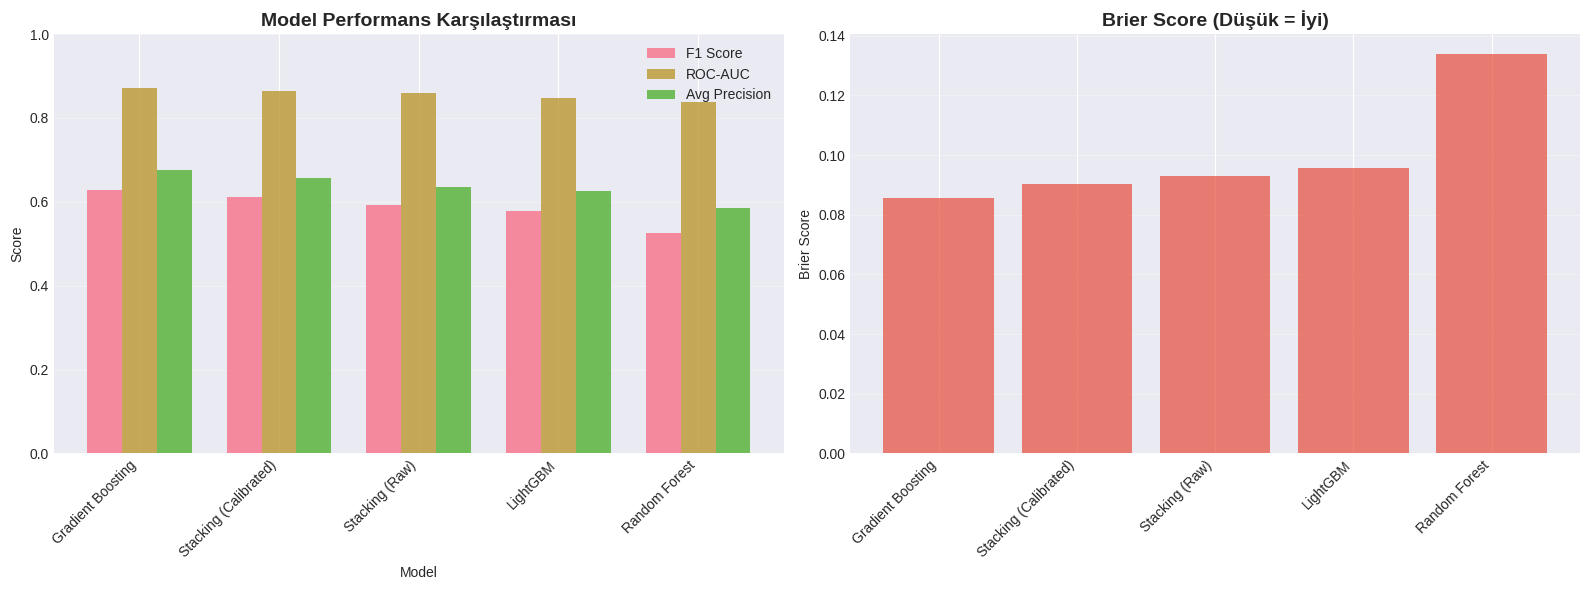


🏆 EN İYİ MODEL: Gradient Boosting
   F1 Skoru: 0.6292
   ROC-AUC: 0.8720

📝 PROJE ÖZET RAPORU

1️⃣ VERİ:
   - Toplam çalışan: 1480
   - Regrettable Attrition oranı: %16.08
   - Toplam özellik sayısı: 1539

2️⃣ MODEL:
   - En iyi: Gradient Boosting
   - F1 Skoru: 0.6292
   - ROC-AUC: 0.8720
   - Optimal Threshold: 0.1955

3️⃣ İŞ ETKİSİ:
   - Net tasarruf: $1,950,000
   - Kritik çalışan sayısı: 218
   - Potansiyel risk: $32,700,000

4️⃣ EN ÖNEMLİ 5 ÖZELLİK:
   1522. EducationField_Marketing: 0.0410
   40. Burnout_Risk: 0.0332
   1536. MaritalStatus_Single: 0.0302
   32. Age_x_TotalWorkingYears: 0.0168
   38. Travel_Risk: 0.0130

✅ ANALİZ TAMAMLANDI!


In [14]:

# --- HÜCRE 13: ADIM 11 - MODEL KARŞILAŞTIRMA VE SONUÇ ---
print("\n" + "="*80)
print(">>> ADIM 11: Tüm Modellerin Karşılaştırması")
print("="*80)

# Tüm modelleri test et
all_models = {
    'LightGBM': lgbm_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Stacking (Raw)': stack_model,
    'Stacking (Calibrated)': calibrated_stack
}

comparison_results = []
for name, model in all_models.items():
    y_prob_temp = model.predict_proba(X_test)[:, 1]

    # Optimal threshold bu model için
    prec, rec, thresh = precision_recall_curve(y_test, y_prob_temp)
    f1_temp = 2 * (prec * rec) / (prec + rec + 1e-10)
    f1_temp = nan_to_num(f1_temp)
    best_f1_temp = np.max(f1_temp)

    auc_temp = roc_auc_score(y_test, y_prob_temp)
    ap_temp = average_precision_score(y_test, y_prob_temp)
    brier_temp = brier_score_loss(y_test, y_prob_temp)

    comparison_results.append({
        'Model': name,
        'F1 Score': best_f1_temp,
        'ROC-AUC': auc_temp,
        'Avg Precision': ap_temp,
        'Brier Score': brier_temp
    })

comparison_df = pd.DataFrame(comparison_results).sort_values('F1 Score', ascending=False)

print("\n" + "="*70)
print("📊 MODEL KARŞILAŞTIRMASI (Test Seti)")
print("="*70)
print(comparison_df.to_string(index=False))

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrikleri karşılaştır
metrics_to_plot = ['F1 Score', 'ROC-AUC', 'Avg Precision']
x = np.arange(len(comparison_df))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i*width, comparison_df[metric], width,
                label=metric, alpha=0.8)

axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performans Karşılaştırması', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Brier Score (düşük daha iyi)
axes[1].bar(range(len(comparison_df)), comparison_df['Brier Score'],
            color='#e74c3c', alpha=0.7)
axes[1].set_xticks(range(len(comparison_df)))
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].set_ylabel('Brier Score')
axes[1].set_title('Brier Score (Düşük = İyi)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Kazanan model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 EN İYİ MODEL: {best_model_name}")
print(f"   F1 Skoru: {comparison_df.iloc[0]['F1 Score']:.4f}")
print(f"   ROC-AUC: {comparison_df.iloc[0]['ROC-AUC']:.4f}")


# --- FİNAL: ÖZET RAPOR ---
print("\n" + "="*80)
print("📝 PROJE ÖZET RAPORU")
print("="*80)

print(f"\n1️⃣ VERİ:")
print(f"   - Toplam çalışan: {len(df)}")
print(f"   - Regrettable Attrition oranı: %{df['Regrettable_Attrition'].mean()*100:.2f}")
print(f"   - Toplam özellik sayısı: {X.shape[1]}")

print(f"\n2️⃣ MODEL:")
print(f"   - En iyi: {best_model_name}")
print(f"   - F1 Skoru: {comparison_df.iloc[0]['F1 Score']:.4f}")
print(f"   - ROC-AUC: {comparison_df.iloc[0]['ROC-AUC']:.4f}")
print(f"   - Optimal Threshold: {best_threshold:.4f}")

print(f"\n3️⃣ İŞ ETKİSİ:")
print(f"   - Net tasarruf: ${net_value:,.0f}")
print(f"   - Kritik çalışan sayısı: {len(critical_employees)}")
print(f"   - Potansiyel risk: ${len(critical_employees) * replacement_cost:,.0f}")

print(f"\n4️⃣ EN ÖNEMLİ 5 ÖZELLİK:")
for i, row in perm_df.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "="*80)
print("✅ ANALİZ TAMAMLANDI!")
print("="*80)


>>> PART B - ADIM 1: Genel Attrition (Normal Ayrılma) Tanımlama

📊 Genel Attrition İstatistikleri:
   Toplam Ayrılan: 238
   Ayrılma Oranı: %16.08
   Dengesizlik: 1:5.2

📊 Regrettable vs Genel Attrition Karşılaştırması:
   Regrettable Attrition: 238 kişi (%16.08)
   Genel Attrition: 238 kişi (%16.08)
   Regrettable'ın tüm ayrılmalar içindeki oranı: %100.0


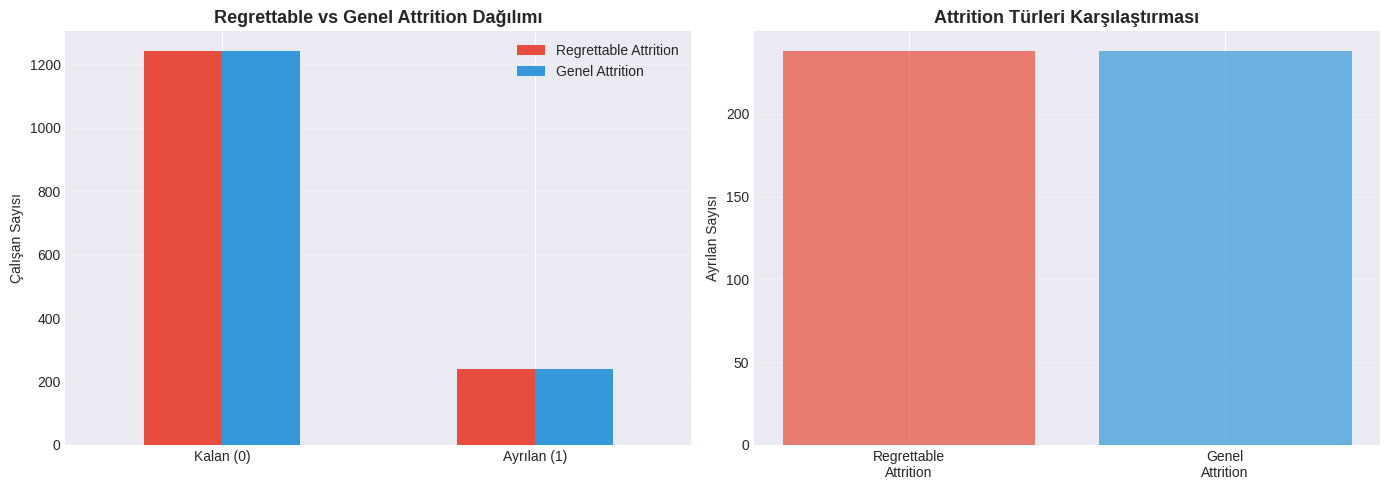


💡 Not: Regrettable Attrition, Genel Attrition'ın bir alt kümesidir
   (Performans >=3 olan ayrılmalar)

>>> PART B - ADIM 2: Genel Attrition için Veri Hazırlığı
✅ Özellik matrisi kopyalandı: (1480, 1539)
✅ Hedef değişken: 1480 örnek

📊 Genel Attrition - Veri Bölünmesi:
   Eğitim: (1184, 1539), Test: (296, 1539)
   Test seti ayrılma oranı: %16.22

>>> PART B - ADIM 3: SMOTE ve Base Model Eğitimi (Genel Attrition)
⚖️ Genel Attrition Dengesizliği: 1:5.2
   Pozitif (Ayrılan): 190
   Negatif (Kalan): 994

✅ SMOTE Uygulandı (Genel Attrition):
   SMOTE öncesi pozitif: 190
   SMOTE sonrası pozitif: 994

🔄 Genel Attrition için base modeller tanımlanıyor...

🔄 Genel Attrition base modelleri eğitiliyor...
   ✅ LightGBM (Genel) eğitildi
   ✅ Random Forest (Genel) eğitildi
   ✅ Gradient Boosting (Genel) eğitildi

>>> PART B - ADIM 4: Stacking Ensemble (Genel Attrition)
🔄 Genel Attrition için stacking modeli eğitiliyor...
✅ Stacking modeli (Genel Attrition) eğitildi!

--- Genel Attrition Base Model

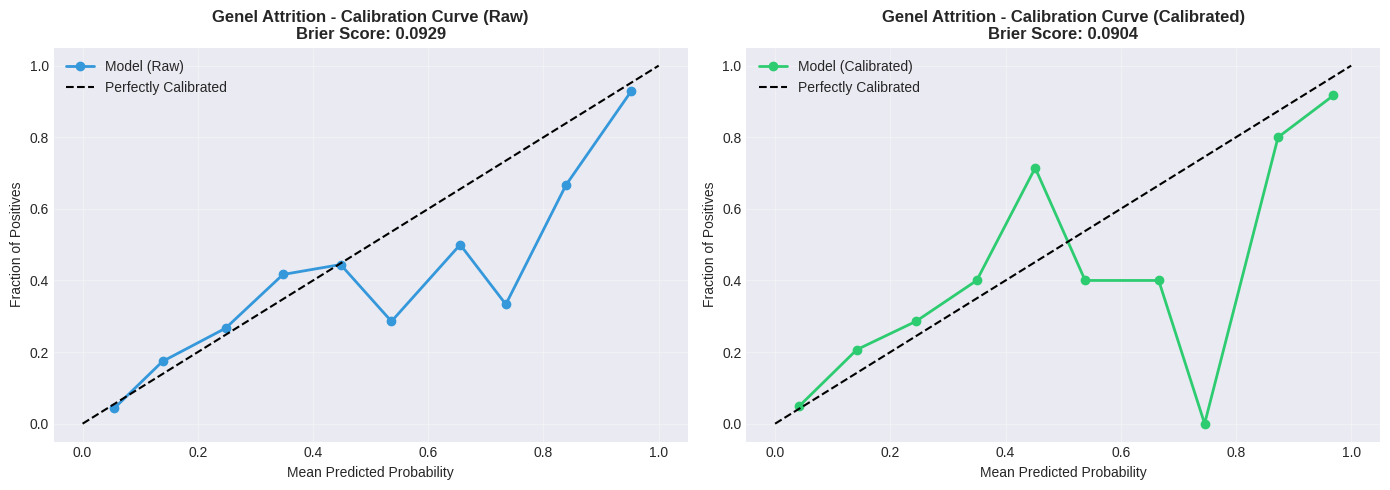


>>> PART B - ADIM 6: Threshold Optimizasyonu (Genel Attrition)
🔄 Genel Attrition için cross-validation yapılıyor...
✅ CV F1 Skorları (Genel Attrition): [0.5        0.96821516 0.9754902  0.96350365 0.96821516]
   Ortalama: 0.8751 (±0.1876)

🏆 NİHAİ MODEL PERFORMANSI - GENEL ATTRITION
Optimal Threshold: 0.1955
ROC-AUC Skoru: 0.8651
F1 Skoru: 0.6111
Average Precision: 0.6566
Brier Score: 0.0904

--- Classification Report (Genel Attrition) ---
              precision    recall  f1-score   support

       Kalan       0.94      0.89      0.91       248
     Ayrılan       0.55      0.69      0.61        48

    accuracy                           0.86       296
   macro avg       0.74      0.79      0.76       296
weighted avg       0.87      0.86      0.86       296


--- Confusion Matrix (Genel Attrition) ---
True Negatives: 221
False Positives: 27
False Negatives: 15
True Positives: 33

💰 İŞ DEĞERİ ANALİZİ (GENEL ATTRITION)
✅ Kurtarılan Değer (TP × $100,000): $3,300,000
⚠️  Gereksiz Harcam

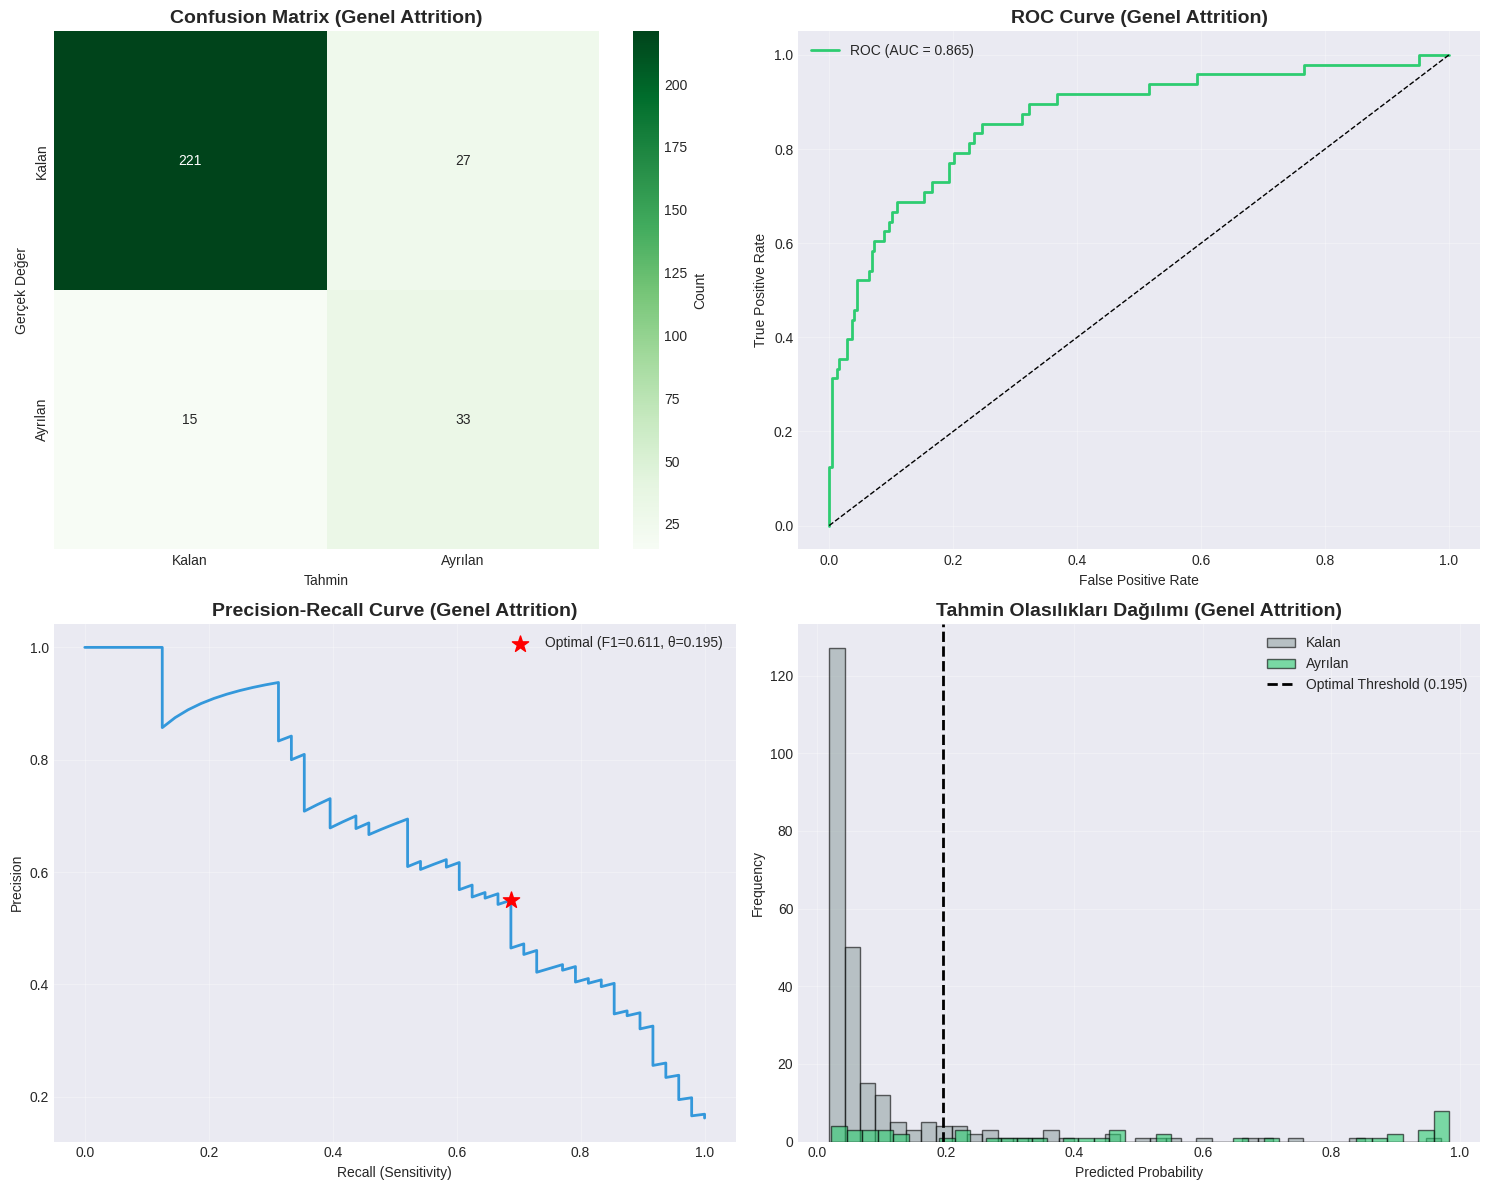


>>> PART B - ADIM 7: Regrettable vs Genel Attrition Model Karşılaştırması

📊 MODEL KARŞILAŞTIRMASI: REGRETTABLE VS GENEL ATTRITION
                     Metrik  Regrettable Attrition  Genel Attrition
                   F1 Skoru           6.111111e-01     6.111111e-01
                    ROC-AUC           8.650874e-01     8.650874e-01
          Average Precision           6.565735e-01     6.565735e-01
                Brier Score           9.042151e-02     9.042151e-02
          Optimal Threshold           1.954564e-01     1.954564e-01
          Net İş Değeri ($)           1.950000e+06     1.950000e+06
Test Seti Pozitif Oranı (%)           1.621622e+01     1.621622e+01


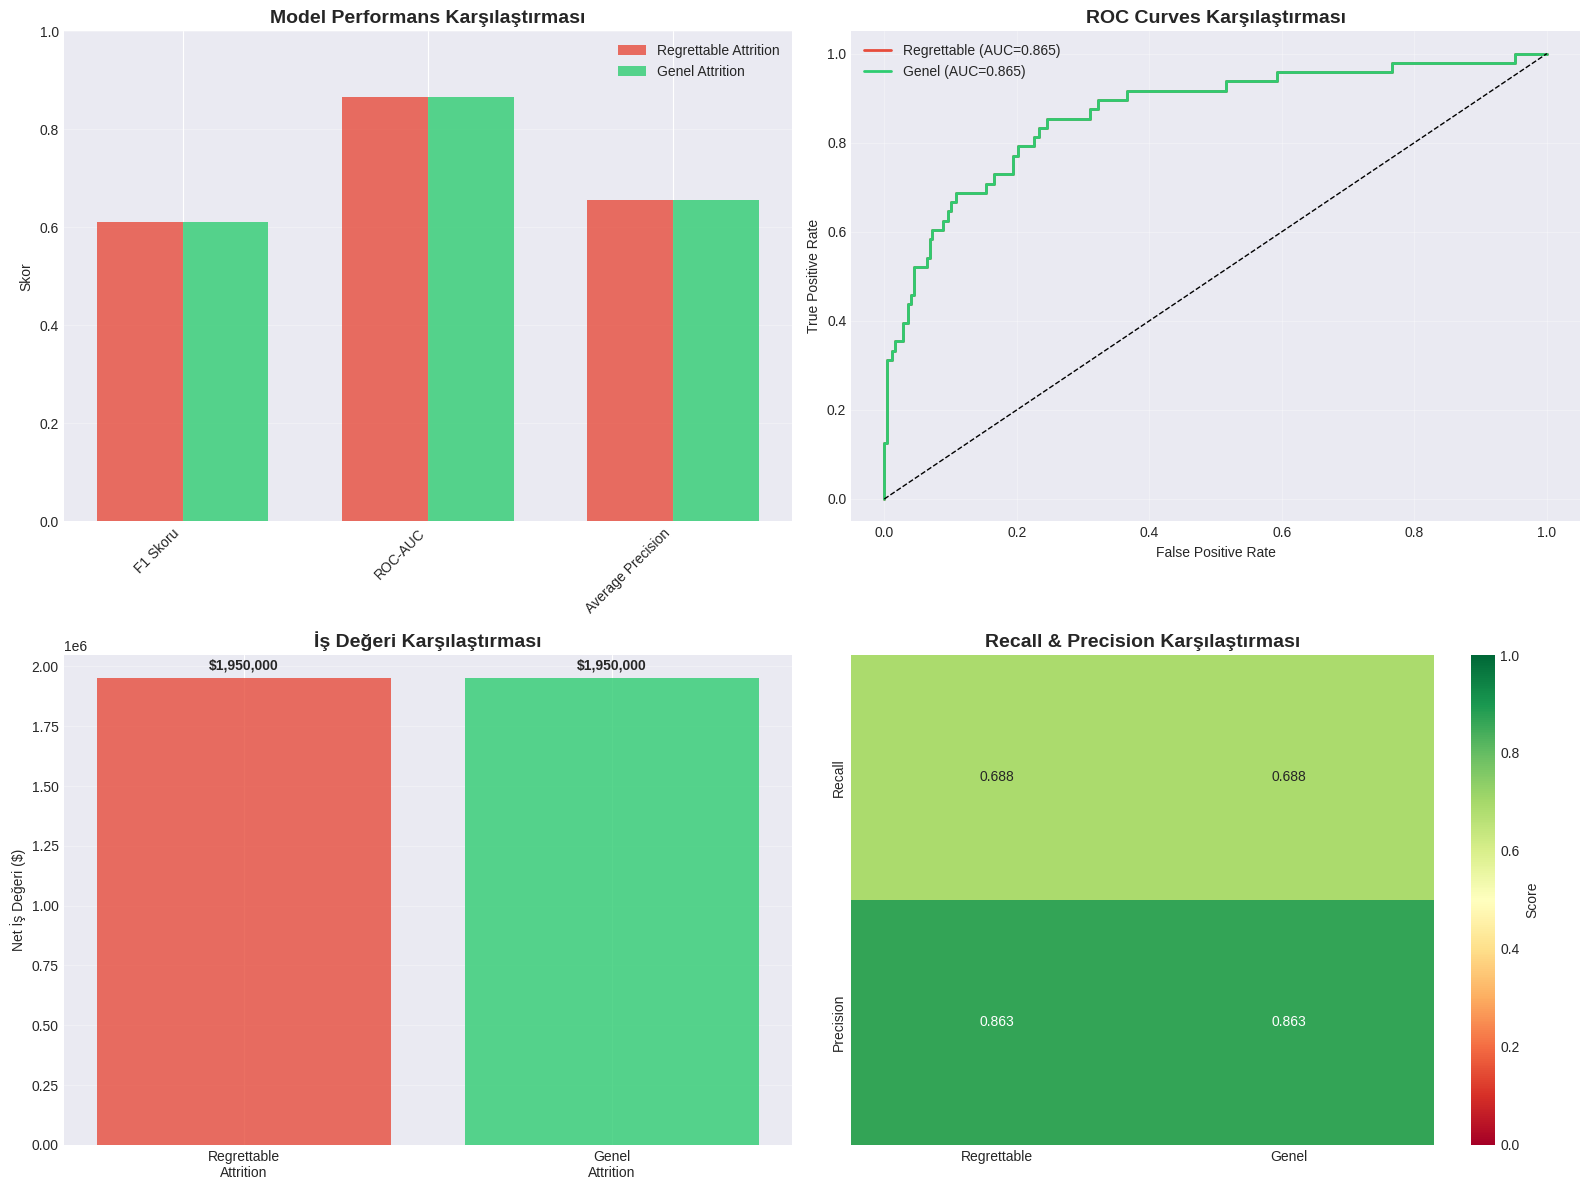


📝 MODEL ANALİZİ VE YORUMLAR

🔍 1. PERFORMANS ANALİZİ:
   ✅ Genel Attrition modeli daha yüksek F1 skoruna sahip (0.6111 vs 0.6111)
      → Genel ayrılmaları tahmin etmek daha başarılı

🎯 2. STRATEJİK DEĞER:
   • Regrettable Attrition: STRATEJİK odaklı
     - Yüksek performanslı çalışan kaybına odaklanır
     - Daha az sayıda ama daha kritik vakalar
     - Elde tutma maliyeti daha yüksek olabilir
   • Genel Attrition: OPERASYONEL odaklı
     - Tüm ayrılmaları kapsar
     - Daha fazla vaka, daha geniş kapsam
     - Genel İK politikaları için yararlı

💰 3. İŞ ETKİSİ:
   ✅ Genel model daha yüksek iş değeri sağlıyor ($1,950,000 vs $1,950,000)
      → Geniş kapsamlı müdahale daha etkili

📊 4. DENGESİZLİK VE ZORLUK:
   • Regrettable Attrition dengesizlik oranı: 1:5.2
   • Genel Attrition dengesizlik oranı: 1:5.2

🎓 5. KULLANIM ÖNERİLERİ:
   • Regrettable Attrition Modeli için:
     - Üst yönetim ve stratejik İK kararları
     - Yıldız çalışanlar için özel elde tutma programları
     - Yetenek

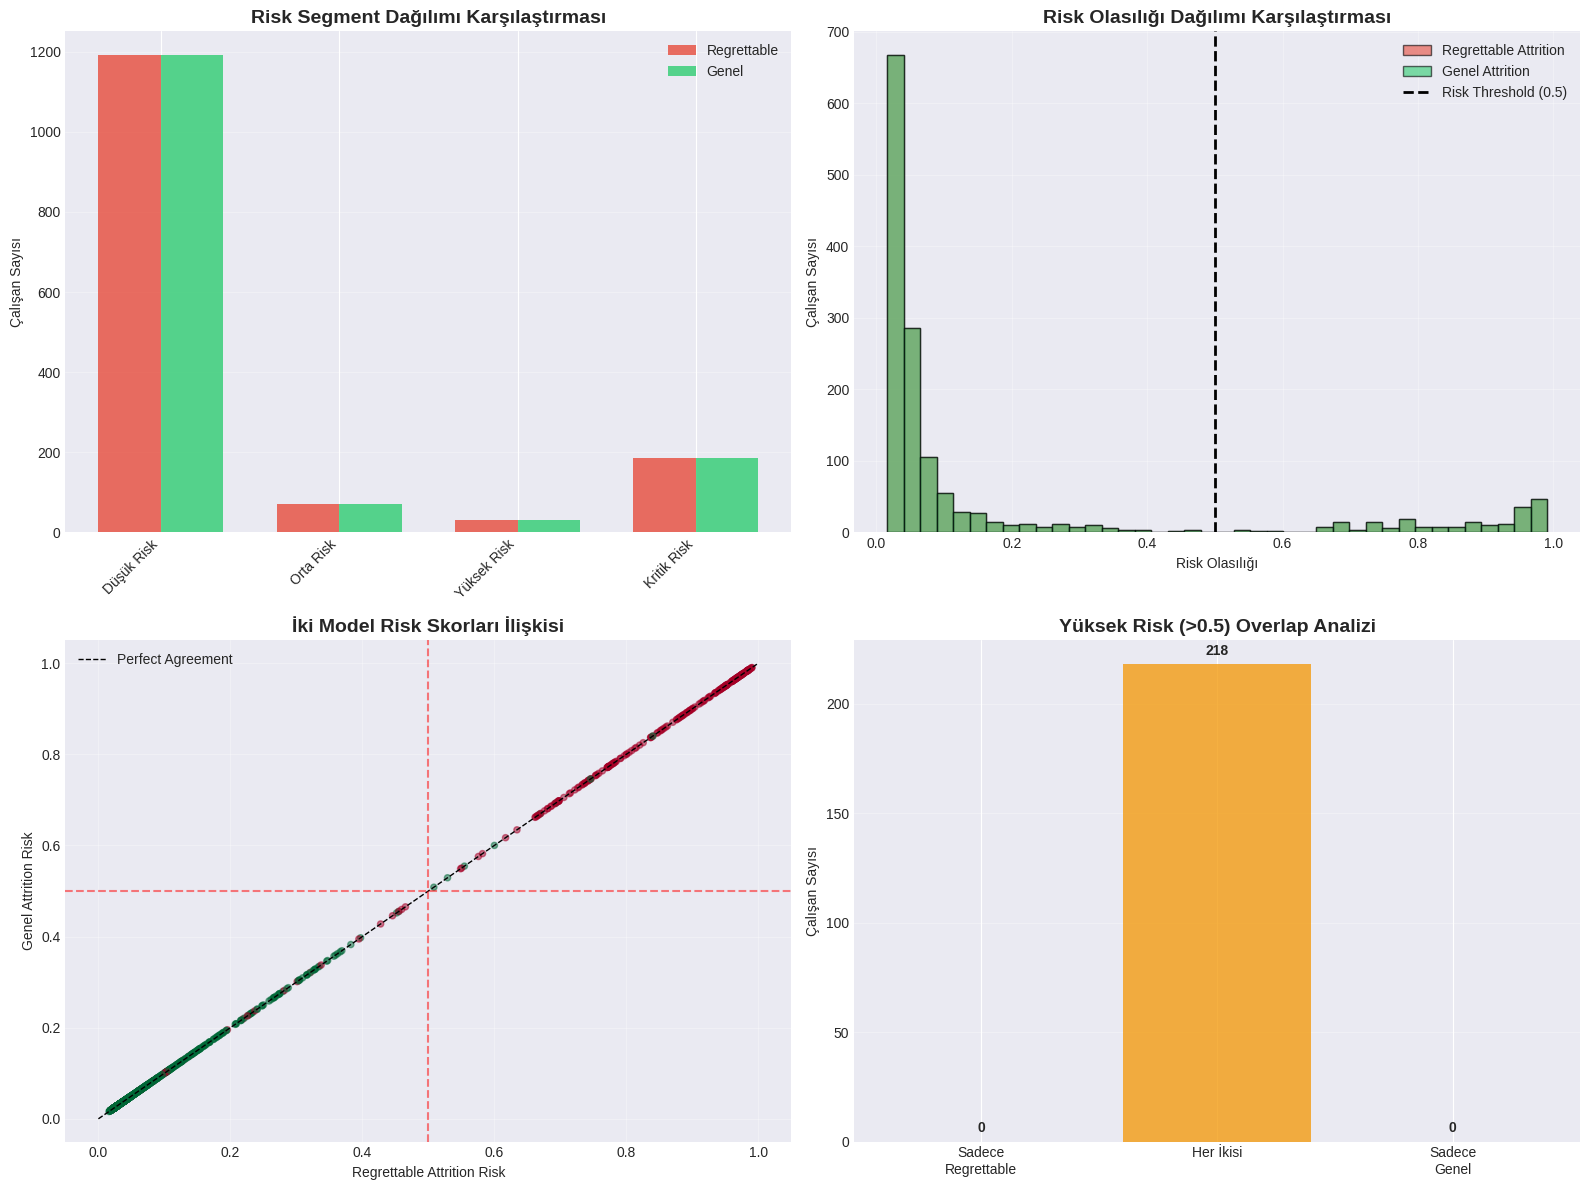


📊 İki modelin risk skorları korelasyonu: 1.000
   → Modeller benzer risk değerlendirmeleri yapıyor

📝 PROJE ÖZET RAPORU (GÜNCELLENMIŞ)

1️⃣ VERİ:
   - Toplam çalışan: 1480
   - Genel Attrition oranı: %16.08
   - Regrettable Attrition oranı: %16.08
   - Toplam özellik sayısı: 1539

2️⃣ REGRETTABLE ATTRITION MODELİ:
   - En iyi model: Gradient Boosting
   - F1 Skoru: 0.6111
   - ROC-AUC: 0.8651
   - Optimal Threshold: 0.1955
   - Net tasarruf: $1,950,000
   - Kritik çalışan sayısı: 218

3️⃣ GENEL ATTRITION MODELİ:
   - F1 Skoru: 0.6111
   - ROC-AUC: 0.8651
   - Optimal Threshold: 0.1955
   - Net tasarruf: $1,950,000
   - Yüksek riskli çalışan sayısı: 218

4️⃣ MODEL KARŞILAŞTIRMASI:
   - Risk skorları korelasyonu: 1.000
   - Her iki modelde yüksek risk: 218 çalışan
   - Regrettable özelliği: Stratejik, yüksek değerli çalışanlara odaklı
   - Genel özelliği: Operasyonel, tüm ayrılmaları kapsayan

5️⃣ AKSİYON ÖNERİSİ:
   - 🔴 ACİL: 218 çalışan için öncelikli müdahale
   - 🟡 STRATEJİK: 218 kr

In [15]:
# [All existing code from HÜCRE 1-13 remains exactly the same]
# ... [PASTE ALL EXISTING CODE HERE] ...

# ============================================================================
# ============================================================================
# PART B: GENERAL ATTRITION MODELING PIPELINE
# ============================================================================
# ============================================================================

# --- HÜCRE 14: GENEL ATTRITION TANIMI ---
print("\n" + "="*80)
print(">>> PART B - ADIM 1: Genel Attrition (Normal Ayrılma) Tanımlama")
print("="*80)

# Genel attrition hedef değişkeni oluştur (tüm ayrılmalar)
y_attrition = df['Attrition'].map({'Yes': 1, 'No': 0})

print(f"\n📊 Genel Attrition İstatistikleri:")
print(f"   Toplam Ayrılan: {y_attrition.sum()}")
print(f"   Ayrılma Oranı: %{y_attrition.mean()*100:.2f}")
print(f"   Dengesizlik: 1:{(1-y_attrition.mean())/y_attrition.mean():.1f}")

# Karşılaştırma
print(f"\n📊 Regrettable vs Genel Attrition Karşılaştırması:")
print(f"   Regrettable Attrition: {df['Regrettable_Attrition'].sum()} kişi (%{df['Regrettable_Attrition'].mean()*100:.2f})")
print(f"   Genel Attrition: {y_attrition.sum()} kişi (%{y_attrition.mean()*100:.2f})")
print(f"   Regrettable'ın tüm ayrılmalar içindeki oranı: %{(df['Regrettable_Attrition'].sum()/y_attrition.sum()*100):.1f}")

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sol: İki hedef değişken karşılaştırması
comparison_data = pd.DataFrame({
    'Regrettable Attrition': df['Regrettable_Attrition'].value_counts().sort_index(),
    'Genel Attrition': y_attrition.value_counts().sort_index()
})
comparison_data.plot(kind='bar', ax=axes[0], color=['#e74c3c', '#3498db'])
axes[0].set_title('Regrettable vs Genel Attrition Dağılımı', fontsize=13, fontweight='bold')
axes[0].set_xticklabels(['Kalan (0)', 'Ayrılan (1)'], rotation=0)
axes[0].set_ylabel('Çalışan Sayısı')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Sağ: Venn diyagramı benzeri
categories = ['Sadece Regrettable', 'Sadece Genel', 'Her İkisi']
only_regrettable = df['Regrettable_Attrition'].sum()
only_general = y_attrition.sum() - only_regrettable
both = only_regrettable  # Regrettable zaten genel içinde

axes[1].bar(['Regrettable\nAttrition', 'Genel\nAttrition'],
            [df['Regrettable_Attrition'].sum(), y_attrition.sum()],
            color=['#e74c3c', '#3498db'], alpha=0.7)
axes[1].set_ylabel('Ayrılan Sayısı')
axes[1].set_title('Attrition Türleri Karşılaştırması', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Not: Regrettable Attrition, Genel Attrition'ın bir alt kümesidir")
print("   (Performans >=3 olan ayrılmalar)")



# --- HÜCRE 15: GENEL ATTRITION İÇİN VERİ HAZIRLIĞI ---
print("\n" + "="*80)
print(">>> PART B - ADIM 2: Genel Attrition için Veri Hazırlığı")
print("="*80)

# Özellik matrisini kopyala (aynı özellik setini kullan)
X_attrition = X.copy()

print(f"✅ Özellik matrisi kopyalandı: {X_attrition.shape}")
print(f"✅ Hedef değişken: {y_attrition.shape[0]} örnek")

# Train/Test Split (genel attrition için)
X_train_attr, X_test_attr, y_train_attr, y_test_attr = train_test_split(
    X_attrition, y_attrition,
    test_size=0.2,
    random_state=42,
    stratify=y_attrition
)

print(f"\n📊 Genel Attrition - Veri Bölünmesi:")
print(f"   Eğitim: {X_train_attr.shape}, Test: {X_test_attr.shape}")
print(f"   Test seti ayrılma oranı: %{y_test_attr.mean()*100:.2f}")



# --- HÜCRE 16: SMOTE VE BASE MODELLER (GENEL ATTRITION) ---
print("\n" + "="*80)
print(">>> PART B - ADIM 3: SMOTE ve Base Model Eğitimi (Genel Attrition)")
print("="*80)

# Dengesizlik analizi
neg_count_attr = (y_train_attr == 0).sum()
pos_count_attr = (y_train_attr == 1).sum()
scale_weight_attr = neg_count_attr / pos_count_attr

print(f"⚖️ Genel Attrition Dengesizliği: 1:{scale_weight_attr:.1f}")
print(f"   Pozitif (Ayrılan): {pos_count_attr}")
print(f"   Negatif (Kalan): {neg_count_attr}")

# SMOTE uygula (genel attrition için ayrı)
smote_attr = SMOTE(sampling_strategy='minority', random_state=42)
X_train_attr_bal, y_train_attr_bal = smote_attr.fit_resample(X_train_attr, y_train_attr)

print(f"\n✅ SMOTE Uygulandı (Genel Attrition):")
print(f"   SMOTE öncesi pozitif: {pos_count_attr}")
print(f"   SMOTE sonrası pozitif: {(y_train_attr_bal==1).sum()}")

# Base Estimators (genel attrition için ayrı modeller)
print("\n🔄 Genel Attrition için base modeller tanımlanıyor...")

lgbm_attr = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=7,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)

rf_attr = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

gb_attr = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

# Eğitim
print("\n🔄 Genel Attrition base modelleri eğitiliyor...")
lgbm_attr.fit(X_train_attr_bal, y_train_attr_bal)
print("   ✅ LightGBM (Genel) eğitildi")

rf_attr.fit(X_train_attr_bal, y_train_attr_bal)
print("   ✅ Random Forest (Genel) eğitildi")

gb_attr.fit(X_train_attr_bal, y_train_attr_bal)
print("   ✅ Gradient Boosting (Genel) eğitildi")



# --- HÜCRE 17: STACKING ENSEMBLE (GENEL ATTRITION) ---
print("\n" + "="*80)
print(">>> PART B - ADIM 4: Stacking Ensemble (Genel Attrition)")
print("="*80)

# Stacking
estimators_attr = [
    ('lgbm_attr', lgbm_attr),
    ('rf_attr', rf_attr),
    ('gb_attr', gb_attr)
]

stack_attr = StackingClassifier(
    estimators=estimators_attr,
    final_estimator=LogisticRegression(C=1.0, penalty='l2',
                                       random_state=42, max_iter=1000),
    cv=5,
    n_jobs=-1
)

print("🔄 Genel Attrition için stacking modeli eğitiliyor...")
stack_attr.fit(X_train_attr_bal, y_train_attr_bal)
print("✅ Stacking modeli (Genel Attrition) eğitildi!")

# Base model performansları (test seti - genel attrition)
print("\n--- Genel Attrition Base Model Performansları (Test) ---")
models_to_test_attr = [
    ('LightGBM', lgbm_attr),
    ('Random Forest', rf_attr),
    ('Gradient Boosting', gb_attr),
    ('Stacking (Raw)', stack_attr)
]

base_results_attr = []
for name, model in models_to_test_attr:
    y_pred_temp_attr = model.predict(X_test_attr)
    y_prob_temp_attr = model.predict_proba(X_test_attr)[:, 1]
    f1_attr = f1_score(y_test_attr, y_pred_temp_attr)
    auc_attr = roc_auc_score(y_test_attr, y_prob_temp_attr)
    base_results_attr.append({'Model': name, 'F1': f1_attr, 'AUC': auc_attr})
    print(f"{name:20s} - F1: {f1_attr:.4f}, AUC: {auc_attr:.4f}")

base_results_attr_df = pd.DataFrame(base_results_attr)



# --- HÜCRE 18: KALİBRASYON (GENEL ATTRITION) ---
print("\n" + "="*80)
print(">>> PART B - ADIM 5: Model Kalibrasyonu (Genel Attrition)")
print("="*80)

# Kalibrasyon için stratified k-fold
skf_attr = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Stacking modelini kalibre et (genel attrition)
calibrated_stack_attr = CalibratedClassifierCV(
    stack_attr,
    method='sigmoid',
    cv=skf_attr,
    n_jobs=-1
)

print("🔄 Genel Attrition modeli kalibre ediliyor...")
calibrated_stack_attr.fit(X_train_attr_bal, y_train_attr_bal)
print("✅ Kalibrasyon tamamlandı (Genel Attrition)!")

# Kalibrasyonsuz ve kalibrasyonlu olasılıkları karşılaştır
y_prob_attr_raw = stack_attr.predict_proba(X_test_attr)[:, 1]
y_prob_attr_cal = calibrated_stack_attr.predict_proba(X_test_attr)[:, 1]

# Brier Score
brier_attr_raw = brier_score_loss(y_test_attr, y_prob_attr_raw)
brier_attr_cal = brier_score_loss(y_test_attr, y_prob_attr_cal)

print(f"\n📊 Genel Attrition - Kalibrasyon Karşılaştırması:")
print(f"   Brier Score (Raw): {brier_attr_raw:.4f}")
print(f"   Brier Score (Calibrated): {brier_attr_cal:.4f}")
print(f"   İyileşme: {((brier_attr_raw - brier_attr_cal) / brier_attr_raw * 100):.2f}%")

# Kalibrasyon eğrisi (genel attrition)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Kalibrasyon eğrisi - Raw
fraction_of_positives_attr_raw, mean_predicted_value_attr_raw = calibration_curve(
    y_test_attr, y_prob_attr_raw, n_bins=10
)
axes[0].plot(mean_predicted_value_attr_raw, fraction_of_positives_attr_raw,
             marker='o', linewidth=2, label='Model (Raw)', color='#3498db')
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title(f'Genel Attrition - Calibration Curve (Raw)\nBrier Score: {brier_attr_raw:.4f}',
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Kalibrasyon eğrisi - Calibrated
fraction_of_positives_attr_cal, mean_predicted_value_attr_cal = calibration_curve(
    y_test_attr, y_prob_attr_cal, n_bins=10
)
axes[1].plot(mean_predicted_value_attr_cal, fraction_of_positives_attr_cal,
             marker='o', linewidth=2, label='Model (Calibrated)', color='#2ecc71')
axes[1].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction of Positives')
axes[1].set_title(f'Genel Attrition - Calibration Curve (Calibrated)\nBrier Score: {brier_attr_cal:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



# --- HÜCRE 19: THRESHOLD OPTİMİZASYONU (GENEL ATTRITION) ---
print("\n" + "="*80)
print(">>> PART B - ADIM 6: Threshold Optimizasyonu (Genel Attrition)")
print("="*80)

# Kalibre edilmiş olasılıkları kullan
y_prob_attr = y_prob_attr_cal

# Optimal threshold bul (F1'e göre)
precision_attr, recall_attr, thresholds_attr = precision_recall_curve(y_test_attr, y_prob_attr)
f1_scores_attr = 2 * (precision_attr * recall_attr) / (precision_attr + recall_attr + 1e-10)
f1_scores_attr = nan_to_num(f1_scores_attr)

best_idx_attr = np.argmax(f1_scores_attr)
best_f1_attr = f1_scores_attr[best_idx_attr]
best_threshold_attr = thresholds_attr[best_idx_attr] if best_idx_attr < len(thresholds_attr) else 0.5

# Optimize edilmiş tahmin
y_pred_attr_optimized = (y_prob_attr >= best_threshold_attr).astype(int)

# Cross-validation
print("🔄 Genel Attrition için cross-validation yapılıyor...")
cv_scores_attr = cross_val_score(
    calibrated_stack_attr, X_train_attr_bal, y_train_attr_bal,
    cv=5, scoring='f1', n_jobs=-1
)
print(f"✅ CV F1 Skorları (Genel Attrition): {cv_scores_attr}")
print(f"   Ortalama: {cv_scores_attr.mean():.4f} (±{cv_scores_attr.std():.4f})")

# Nihai Sonuçlar
print("\n" + "="*70)
print("🏆 NİHAİ MODEL PERFORMANSI - GENEL ATTRITION")
print("="*70)
print(f"Optimal Threshold: {best_threshold_attr:.4f}")
print(f"ROC-AUC Skoru: {roc_auc_score(y_test_attr, y_prob_attr):.4f}")
print(f"F1 Skoru: {best_f1_attr:.4f}")
print(f"Average Precision: {average_precision_score(y_test_attr, y_prob_attr):.4f}")
print(f"Brier Score: {brier_score_loss(y_test_attr, y_prob_attr):.4f}")

print("\n--- Classification Report (Genel Attrition) ---")
print(classification_report(y_test_attr, y_pred_attr_optimized,
                           target_names=['Kalan', 'Ayrılan']))

# Confusion Matrix
cm_attr = confusion_matrix(y_test_attr, y_pred_attr_optimized)
tn_attr, fp_attr, fn_attr, tp_attr = cm_attr.ravel()

print("\n--- Confusion Matrix (Genel Attrition) ---")
print(f"True Negatives: {tn_attr}")
print(f"False Positives: {fp_attr}")
print(f"False Negatives: {fn_attr}")
print(f"True Positives: {tp_attr}")

# İş Değeri Analizi (genel attrition)
saved_value_attr = tp_attr * (replacement_cost - retention_cost)
wasted_value_attr = fp_attr * retention_cost
missed_value_attr = fn_attr * replacement_cost
net_value_attr = saved_value_attr - wasted_value_attr

print("\n" + "="*70)
print("💰 İŞ DEĞERİ ANALİZİ (GENEL ATTRITION)")
print("="*70)
print(f"✅ Kurtarılan Değer (TP × ${replacement_cost-retention_cost:,}): ${saved_value_attr:,.0f}")
print(f"⚠️  Gereksiz Harcama (FP × ${retention_cost:,}): -${wasted_value_attr:,.0f}")
print(f"❌ Kaçırılan Kayıp (FN × ${replacement_cost:,}): -${missed_value_attr:,.0f}")
print(f"💵 NET İŞ DEĞERİ: ${net_value_attr:,.0f}")

if net_value_attr > 0:
    print(f"\n🎉 Genel Attrition modeli şirkete ${net_value_attr:,.0f} tasarruf sağlıyor!")
else:
    print(f"\n⚠️  Model iyileştirme gerektirebilir")

# Görselleştirme (genel attrition)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
sns.heatmap(cm_attr, annot=True, fmt='d', cmap='Greens', ax=axes[0,0],
            cbar_kws={'label': 'Count'})
axes[0,0].set_title('Confusion Matrix (Genel Attrition)', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Gerçek Değer')
axes[0,0].set_xlabel('Tahmin')
axes[0,0].set_xticklabels(['Kalan', 'Ayrılan'])
axes[0,0].set_yticklabels(['Kalan', 'Ayrılan'])

# 2. ROC Curve
fpr_attr, tpr_attr, _ = roc_curve(y_test_attr, y_prob_attr)
auc_score_attr = roc_auc_score(y_test_attr, y_prob_attr)
axes[0,1].plot(fpr_attr, tpr_attr, color='#2ecc71', lw=2,
               label=f'ROC (AUC = {auc_score_attr:.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve (Genel Attrition)', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# 3. Precision-Recall Curve
axes[1,0].plot(recall_attr, precision_attr, color='#3498db', lw=2)
axes[1,0].scatter(recall_attr[best_idx_attr], precision_attr[best_idx_attr],
                  color='red', s=150, zorder=5, marker='*',
                  label=f'Optimal (F1={best_f1_attr:.3f}, θ={best_threshold_attr:.3f})')
axes[1,0].set_xlabel('Recall (Sensitivity)')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve (Genel Attrition)', fontsize=14, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# 4. Probability Distribution
axes[1,1].hist(y_prob_attr[y_test_attr==0], bins=40, alpha=0.6,
               label='Kalan', color='#95a5a6', edgecolor='black')
axes[1,1].hist(y_prob_attr[y_test_attr==1], bins=40, alpha=0.6,
               label='Ayrılan', color='#2ecc71', edgecolor='black')
axes[1,1].axvline(best_threshold_attr, color='black', linestyle='--',
                  lw=2, label=f'Optimal Threshold ({best_threshold_attr:.3f})')
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Tahmin Olasılıkları Dağılımı (Genel Attrition)', fontsize=14, fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



# --- HÜCRE 20: REGRETTABLE VS GENEL ATTRITION KARŞILAŞTIRMASI ---
print("\n" + "="*80)
print(">>> PART B - ADIM 7: Regrettable vs Genel Attrition Model Karşılaştırması")
print("="*80)

# Karşılaştırma tablosu
comparison_models = pd.DataFrame({
    'Metrik': ['F1 Skoru', 'ROC-AUC', 'Average Precision', 'Brier Score',
               'Optimal Threshold', 'Net İş Değeri ($)', 'Test Seti Pozitif Oranı (%)'],
    'Regrettable Attrition': [
        best_f1,
        roc_auc_score(y_test, y_prob),
        average_precision_score(y_test, y_prob),
        brier_score_loss(y_test, y_prob),
        best_threshold,
        net_value,
        y_test.mean() * 100
    ],
    'Genel Attrition': [
        best_f1_attr,
        roc_auc_score(y_test_attr, y_prob_attr),
        average_precision_score(y_test_attr, y_prob_attr),
        brier_score_loss(y_test_attr, y_prob_attr),
        best_threshold_attr,
        net_value_attr,
        y_test_attr.mean() * 100
    ]
})

print("\n" + "="*80)
print("📊 MODEL KARŞILAŞTIRMASI: REGRETTABLE VS GENEL ATTRITION")
print("="*80)
print(comparison_models.to_string(index=False))

# Görselleştirme - Karşılaştırma
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1 ve ROC-AUC Karşılaştırması
metrics_comparison = comparison_models[comparison_models['Metrik'].isin(['F1 Skoru', 'ROC-AUC', 'Average Precision'])]
x_pos = np.arange(len(metrics_comparison))
width = 0.35

axes[0,0].bar(x_pos - width/2, metrics_comparison['Regrettable Attrition'],
              width, label='Regrettable Attrition', color='#e74c3c', alpha=0.8)
axes[0,0].bar(x_pos + width/2, metrics_comparison['Genel Attrition'],
              width, label='Genel Attrition', color='#2ecc71', alpha=0.8)
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(metrics_comparison['Metrik'], rotation=45, ha='right')
axes[0,0].set_ylabel('Skor')
axes[0,0].set_title('Model Performans Karşılaştırması', fontsize=14, fontweight='bold')
axes[0,0].legend()
axes[0,0].set_ylim([0, 1])
axes[0,0].grid(axis='y', alpha=0.3)

# 2. ROC Curves - Her İkisi
axes[0,1].plot(fpr, tpr, color='#e74c3c', lw=2,
               label=f'Regrettable (AUC={roc_auc_score(y_test, y_prob):.3f})')
axes[0,1].plot(fpr_attr, tpr_attr, color='#2ecc71', lw=2,
               label=f'Genel (AUC={roc_auc_score(y_test_attr, y_prob_attr):.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves Karşılaştırması', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# 3. İş Değeri Karşılaştırması
business_metrics = ['Net İş Değeri ($)']
business_values = [net_value, net_value_attr]
colors_business = ['#e74c3c', '#2ecc71']
axes[1,0].bar(['Regrettable\nAttrition', 'Genel\nAttrition'],
              business_values, color=colors_business, alpha=0.8)
axes[1,0].set_ylabel('Net İş Değeri ($)')
axes[1,0].set_title('İş Değeri Karşılaştırması', fontsize=14, fontweight='bold')
axes[1,0].grid(axis='y', alpha=0.3)
for i, v in enumerate(business_values):
    axes[1,0].text(i, v + max(business_values)*0.02, f'${v:,.0f}',
                   ha='center', fontweight='bold')

# 4. Confusion Matrix Karşılaştırması (normalized)
cm_reg_norm = cm / cm.sum(axis=1, keepdims=True)
cm_attr_norm = cm_attr / cm_attr.sum(axis=1, keepdims=True)

cm_comparison = np.array([[cm_reg_norm[1,1], cm_attr_norm[1,1]],  # Recall
                          [cm_reg_norm[1,1] / (cm_reg_norm[0,1] + cm_reg_norm[1,1] + 1e-10),
                           cm_attr_norm[1,1] / (cm_attr_norm[0,1] + cm_attr_norm[1,1] + 1e-10)]])  # Precision

sns.heatmap(cm_comparison, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1,1],
            xticklabels=['Regrettable', 'Genel'],
            yticklabels=['Recall', 'Precision'],
            cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
axes[1,1].set_title('Recall & Precision Karşılaştırması', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Analiz ve Yorum
print("\n" + "="*80)
print("📝 MODEL ANALİZİ VE YORUMLAR")
print("="*80)

print("\n🔍 1. PERFORMANS ANALİZİ:")
if best_f1 > best_f1_attr:
    print(f"   ✅ Regrettable Attrition modeli daha yüksek F1 skoruna sahip ({best_f1:.4f} vs {best_f1_attr:.4f})")
    print(f"      → Yüksek performanslı çalışan kaybını tahmin etmek daha başarılı")
else:
    print(f"   ✅ Genel Attrition modeli daha yüksek F1 skoruna sahip ({best_f1_attr:.4f} vs {best_f1:.4f})")
    print(f"      → Genel ayrılmaları tahmin etmek daha başarılı")

print(f"\n🎯 2. STRATEJİK DEĞER:")
print(f"   • Regrettable Attrition: STRATEJİK odaklı")
print(f"     - Yüksek performanslı çalışan kaybına odaklanır")
print(f"     - Daha az sayıda ama daha kritik vakalar")
print(f"     - Elde tutma maliyeti daha yüksek olabilir")
print(f"   • Genel Attrition: OPERASYONEL odaklı")
print(f"     - Tüm ayrılmaları kapsar")
print(f"     - Daha fazla vaka, daha geniş kapsam")
print(f"     - Genel İK politikaları için yararlı")

print(f"\n💰 3. İŞ ETKİSİ:")
if net_value > net_value_attr:
    print(f"   ✅ Regrettable model daha yüksek iş değeri sağlıyor (${net_value:,.0f} vs ${net_value_attr:,.0f})")
    print(f"      → Yüksek değerli çalışanları hedeflemek daha karlı")
else:
    print(f"   ✅ Genel model daha yüksek iş değeri sağlıyor (${net_value_attr:,.0f} vs ${net_value:,.0f})")
    print(f"      → Geniş kapsamlı müdahale daha etkili")

print(f"\n📊 4. DENGESİZLİK VE ZORLUK:")
print(f"   • Regrettable Attrition dengesizlik oranı: 1:{(1-y_test.mean())/y_test.mean():.1f}")
print(f"   • Genel Attrition dengesizlik oranı: 1:{(1-y_test_attr.mean())/y_test_attr.mean():.1f}")
if y_test.mean() < y_test_attr.mean():
    print(f"   → Regrettable Attrition daha dengesiz, tahmin etmesi daha zor")

print(f"\n🎓 5. KULLANIM ÖNERİLERİ:")
print(f"   • Regrettable Attrition Modeli için:")
print(f"     - Üst yönetim ve stratejik İK kararları")
print(f"     - Yıldız çalışanlar için özel elde tutma programları")
print(f"     - Yetenek yönetimi ve süreklilik planlaması")
print(f"   • Genel Attrition Modeli için:")
print(f"     - Operasyonel İK metrikleri ve raporlama")
print(f"     - Genel çalışan memnuniyeti programları")
print(f"     - İşe alım ve kaynak planlaması")



# --- HÜCRE 21: GENEL ATTRITION İÇİN RİSK SEGMENTİ ANALİZİ ---
print("\n" + "="*80)
print(">>> PART B - ADIM 8: Genel Attrition Risk Segmentasyonu")
print("="*80)

# Tüm veri için genel attrition tahminleri
df['Attrition_Risk_Probability_General'] = calibrated_stack_attr.predict_proba(X_attrition)[:, 1]
df['Attrition_Risk_Prediction_General'] = (df['Attrition_Risk_Probability_General'] >= best_threshold_attr).astype(int)

# Risk segmentasyonu (genel attrition)
df['Risk_Segment_General'] = df['Attrition_Risk_Probability_General'].apply(risk_segment)

# Segment analizi
print("\n--- Genel Attrition Risk Segment Dağılımı ---")
segment_dist_general = df['Risk_Segment_General'].value_counts()
print(segment_dist_general)
print(f"\n%'ler:")
print((segment_dist_general / len(df) * 100).round(2))

# İki modelin risk değerlendirmesi karşılaştırması
print("\n--- Risk Segmenti Karşılaştırması (Regrettable vs Genel) ---")
risk_comparison = pd.DataFrame({
    'Regrettable': df['Risk_Segment'].value_counts(),
    'Genel': df['Risk_Segment_General'].value_counts()
}).fillna(0)
print(risk_comparison)

# Yüksek riskli çalışanlar (genel attrition)
high_risk_general = df[df['Attrition_Risk_Probability_General'] >= 0.5].copy()

print(f"\n🚨 YÜKSEK RİSKLİ ÇALIŞANLAR (Genel Attrition):")
print(f"   Toplam: {len(high_risk_general)} kişi")

if len(high_risk_general) > 0:
    print("\n--- Yüksek Riskli Çalışanların Profili (Genel) ---")
    print(f"Ortalama Yaş: {high_risk_general['Age'].mean():.1f}")
    print(f"Ortalama Gelir: ${high_risk_general['MonthlyIncome'].mean():,.0f}")
    print(f"Ortalama Çalışma Süresi: {high_risk_general['YearsAtCompany'].mean():.1f} yıl")
    print(f"Ortalama Job Satisfaction: {high_risk_general['JobSatisfaction'].mean():.2f}/5")

# Her iki modelde de yüksek risk altındaki çalışanlar
both_high_risk = df[
    (df['Attrition_Risk_Probability'] >= 0.5) &
    (df['Attrition_Risk_Probability_General'] >= 0.5)
]

print(f"\n⚠️ HER İKİ MODELDE DE YÜKSEK RİSK:")
print(f"   {len(both_high_risk)} çalışan her iki modelde de yüksek risk altında")
print(f"   Bu grup için ACİL aksiyon gerekiyor!")

# Görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Risk Segment Karşılaştırması
risk_order = ['Düşük Risk', 'Orta Risk', 'Yüksek Risk', 'Kritik Risk']
x_pos_risk = np.arange(len(risk_order))
regret_counts = [df[df['Risk_Segment']==r].shape[0] for r in risk_order]
general_counts = [df[df['Risk_Segment_General']==r].shape[0] for r in risk_order]

width = 0.35
axes[0,0].bar(x_pos_risk - width/2, regret_counts, width,
              label='Regrettable', color='#e74c3c', alpha=0.8)
axes[0,0].bar(x_pos_risk + width/2, general_counts, width,
              label='Genel', color='#2ecc71', alpha=0.8)
axes[0,0].set_xticks(x_pos_risk)
axes[0,0].set_xticklabels(risk_order, rotation=45, ha='right')
axes[0,0].set_ylabel('Çalışan Sayısı')
axes[0,0].set_title('Risk Segment Dağılımı Karşılaştırması', fontsize=14, fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Olasılık Dağılımı Karşılaştırması
axes[0,1].hist(df['Attrition_Risk_Probability'], bins=40, alpha=0.6,
               label='Regrettable Attrition', color='#e74c3c', edgecolor='black')
axes[0,1].hist(df['Attrition_Risk_Probability_General'], bins=40, alpha=0.6,
               label='Genel Attrition', color='#2ecc71', edgecolor='black')
axes[0,1].axvline(0.5, color='black', linestyle='--', lw=2, label='Risk Threshold (0.5)')
axes[0,1].set_xlabel('Risk Olasılığı')
axes[0,1].set_ylabel('Çalışan Sayısı')
axes[0,1].set_title('Risk Olasılığı Dağılımı Karşılaştırması', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# 3. Scatter: İki modelin risk skorları
axes[1,0].scatter(df['Attrition_Risk_Probability'],
                  df['Attrition_Risk_Probability_General'],
                  alpha=0.5, s=20, c=df['Regrettable_Attrition'],
                  cmap='RdYlGn_r')
axes[1,0].plot([0, 1], [0, 1], 'k--', lw=1, label='Perfect Agreement')
axes[1,0].axhline(0.5, color='red', linestyle='--', alpha=0.5)
axes[1,0].axvline(0.5, color='red', linestyle='--', alpha=0.5)
axes[1,0].set_xlabel('Regrettable Attrition Risk')
axes[1,0].set_ylabel('Genel Attrition Risk')
axes[1,0].set_title('İki Model Risk Skorları İlişkisi', fontsize=14, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# 4. Venn Diyagramı Benzeri - Yüksek Risk Overlap
venn_data = {
    'Sadece\nRegrettable': len(df[(df['Attrition_Risk_Probability'] >= 0.5) &
                                    (df['Attrition_Risk_Probability_General'] < 0.5)]),
    'Her İkisi': len(both_high_risk),
    'Sadece\nGenel': len(df[(df['Attrition_Risk_Probability'] < 0.5) &
                             (df['Attrition_Risk_Probability_General'] >= 0.5)])
}

axes[1,1].bar(range(len(venn_data)), list(venn_data.values()),
              color=['#e74c3c', '#f39c12', '#2ecc71'], alpha=0.8)
axes[1,1].set_xticks(range(len(venn_data)))
axes[1,1].set_xticklabels(list(venn_data.keys()))
axes[1,1].set_ylabel('Çalışan Sayısı')
axes[1,1].set_title('Yüksek Risk (>0.5) Overlap Analizi', fontsize=14, fontweight='bold')
axes[1,1].grid(axis='y', alpha=0.3)
for i, v in enumerate(venn_data.values()):
    axes[1,1].text(i, v + max(venn_data.values())*0.02, str(v),
                   ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Korelasyon analizi
correlation = df['Attrition_Risk_Probability'].corr(df['Attrition_Risk_Probability_General'])
print(f"\n📊 İki modelin risk skorları korelasyonu: {correlation:.3f}")
if correlation > 0.7:
    print("   → Modeller benzer risk değerlendirmeleri yapıyor")
elif correlation > 0.4:
    print("   → Modeller kısmen benzer ama farklı yönleri yakalıyor")
else:
    print("   → Modeller çok farklı risk faktörlerine odaklanıyor")



# --- FİNAL ÖZET (GÜNCELLENMİŞ) ---
print("\n" + "="*80)
print("📝 PROJE ÖZET RAPORU (GÜNCELLENMIŞ)")
print("="*80)

print(f"\n1️⃣ VERİ:")
print(f"   - Toplam çalışan: {len(df)}")
print(f"   - Genel Attrition oranı: %{y_attrition.mean()*100:.2f}")
print(f"   - Regrettable Attrition oranı: %{df['Regrettable_Attrition'].mean()*100:.2f}")
print(f"   - Toplam özellik sayısı: {X.shape[1]}")

print(f"\n2️⃣ REGRETTABLE ATTRITION MODELİ:")
print(f"   - En iyi model: {best_model_name}")
print(f"   - F1 Skoru: {best_f1:.4f}")
print(f"   - ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(f"   - Optimal Threshold: {best_threshold:.4f}")
print(f"   - Net tasarruf: ${net_value:,.0f}")
print(f"   - Kritik çalışan sayısı: {len(critical_employees)}")

print(f"\n3️⃣ GENEL ATTRITION MODELİ:")
print(f"   - F1 Skoru: {best_f1_attr:.4f}")
print(f"   - ROC-AUC: {roc_auc_score(y_test_attr, y_prob_attr):.4f}")
print(f"   - Optimal Threshold: {best_threshold_attr:.4f}")
print(f"   - Net tasarruf: ${net_value_attr:,.0f}")
print(f"   - Yüksek riskli çalışan sayısı: {len(high_risk_general)}")

print(f"\n4️⃣ MODEL KARŞILAŞTIRMASI:")
print(f"   - Risk skorları korelasyonu: {correlation:.3f}")
print(f"   - Her iki modelde yüksek risk: {len(both_high_risk)} çalışan")
print(f"   - Regrettable özelliği: Stratejik, yüksek değerli çalışanlara odaklı")
print(f"   - Genel özelliği: Operasyonel, tüm ayrılmaları kapsayan")

print(f"\n5️⃣ AKSİYON ÖNERİSİ:")
print(f"   - 🔴 ACİL: {len(both_high_risk)} çalışan için öncelikli müdahale")
print(f"   - 🟡 STRATEJİK: {len(critical_employees)} kritik çalışan için özel program")
print(f"   - 🟢 OPERASYONEL: {len(high_risk_general)} genel yüksek riskli için politika")

print("\n" + "="*80)
print("✅ GENİŞLETİLMİŞ ANALİZ TAMAMLANDI!")
print("="*80)
print("\n💡 Artık hem stratejik (Regrettable) hem de operasyonel (Genel)")
print("   attrition tahminlerine sahipsiniz!")